In [128]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_recall_curve, f1_score, classification_report, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE, RandomOverSampler
import optuna
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.decomposition import PCA

In [92]:
df = pd.read_csv("Transformed_data_v1.0_Final.csv")
df

,Site,Customer ID,ModelChoice_Default_Flag,Creditlens_FIN_ACID_TEST_RATIO,Creditlens_FIN_CFM_GROSS_PROFIT_MARGIN_PERCENT,Creditlens_FIN_CFM_OPERATING_EXPENSE_PERCENT,Creditlens_FIN_CIV_CASH_EQUIVALENTS,Creditlens_FIN_CIV_GROSS_PROFIT,Creditlens_FIN_CIV_INCOME_TAXES_PAYABLE,Creditlens_FIN_CIV_OPERATING_EXPENSE,...,total_4_delq_L1,total_5_delq_L1,total_6_delq_L1,max_mth_num_1_delq_L1,max_mth_num_2_delq_L1,max_mth_num_3_delq_L1,max_mth_num_4_delq_L1,max_mth_num_5_delq_L1,max_mth_num_6_delq_L1,recovery_delq_L1
0,AA,59878,0,3.698561e-01,2.306480e+01,38.329372,7.395092e-01,3.054183e+01,2.108217e+00,3.300819e+01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AA,64594,0,4.509198e-01,9.277703e+00,154.488358,2.999206e+01,1.301444e+01,1.000000e+11,1.515905e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AA,60782,0,1.117330e+00,1.782799e+01,19.103769,1.113960e+01,2.136470e+01,8.253444e-01,1.995375e+01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AA,64172,1,9.851680e-01,1.733061e+01,19.503665,4.171558e+00,2.102938e+01,1.217533e+00,2.021267e+01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AA,62012,0,8.103052e-01,1.726112e+01,17.078385,6.113280e+00,2.115869e+01,1.477698e+00,1.810360e+01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14206,VV,55980,0,1.000000e+11,1.000000e+11,NaN,1.000000e+11,1.000000e+11,1.000000e+11,1.000000e+11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14207,VV,62273,0,1.000000e+11,1.000000e+11,NaN,1.000000e+11,1.000000e+11,1.000000e+11,1.000000e+11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14208,VV,63954,0,1.000000e+11,1.000000e+11,NaN,1.000000e+11,1.000000e+11,1.000000e+11,1.000000e+11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14209,VV,65190,0,1.000000e+11,1.000000e+11,NaN,1.000000e+11,1.000000e+11,1.000000e+11,1.000000e+11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
original_var = df.columns.tolist()
original_var

['Site',
 'Customer ID',
 'ModelChoice_Default_Flag',
 'Creditlens_FIN_ACID_TEST_RATIO',
 'Creditlens_FIN_CFM_GROSS_PROFIT_MARGIN_PERCENT',
 'Creditlens_FIN_CFM_OPERATING_EXPENSE_PERCENT',
 'Creditlens_FIN_CIV_CASH_EQUIVALENTS',
 'Creditlens_FIN_CIV_GROSS_PROFIT',
 'Creditlens_FIN_CIV_INCOME_TAXES_PAYABLE',
 'Creditlens_FIN_CIV_OPERATING_EXPENSE',
 'Creditlens_FIN_CIV_OPERATING_PROFIT',
 'Creditlens_FIN_CIV_PROFIT_BEFORE_TAXES',
 'Creditlens_FIN_CURRENT',
 'Creditlens_FIN_GROSS_PROFIT_MARGIN',
 'Creditlens_FIN_OE_TO_TURNOVER',
 'Creditlens_FIN_OPERATING_LEVERAGE',
 'Creditlens_FIN_OPERATING_PROFIT_MARGIN',
 'Creditlens_FIN_PP_NET_MARGIN',
 'Creditlens_FIN_QUICK',
 'Creditlens_FIN_TURNOVER_TO_WORKING_CAPITAL',
 'Creditlens_FIN_CIV_NET_WORTH',
 'Creditlens_FIN_DEBT_TO_TNW',
 'Internal_Behavior_Flag',
 'max_mth_num_1_int_delq',
 'max_mth_num_2_int_delq',
 'max_mth_num_3_int_delq',
 'max_mth_num_4_int_delq',
 'max_mth_num_5_int_delq',
 'max_mth_num_6_int_delq',
 'total_1_int_delq',
 'total

In [71]:
baseline_var = original_var.copy()
baseline_var.remove('Customer ID')
baseline_var.remove('ModelChoice_Default_Flag')

# Data Precessing

## Segment Dividing

### Dealing with 'Age_of_Company_in_Month'

In [23]:
# 将月份转换为年份
df['Age_of_Company_in_Years'] = df['Age_of_Company_in_Month'] / 12

# 创建年份分段
bins = [0, 2, 5, 10, 20, 50, np.inf]  # 定义分段边界
labels = ['0-2 years', '2-5 years', '6-10 years', '10-20 years', '20-50 years', 'More than 50 years']  # 定义每个分段的标签
df['Age_Category'] = pd.cut(df['Age_of_Company_in_Years'], bins=bins, labels=labels, right=False)

# 检查结果
print(df[['Age_of_Company_in_Month', 'Age_of_Company_in_Years', 'Age_Category']].head())

# 将'Age_Category'列中的缺失值先填充为'Missing'
# 添加新类别 'Missing'
df['Age_Category'] = df['Age_Category'].cat.add_categories(['Missing'])
df['Age_Category'].fillna('Missing', inplace=True)

# 删除原始Age of Company列
# del df['Age_of_Company_in_Month']
# del df['Age_of_Company_in_Years']

   Age_of_Company_in_Month  Age_of_Company_in_Years        Age_Category
0                    173.0                14.416667         10-20 years
1                    185.0                15.416667         10-20 years
2                    996.0                83.000000  More than 50 years
3                   1009.0                84.083333  More than 50 years
4                   1023.0                85.250000  More than 50 years


/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/2349154484.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age_Category'].fillna('Missing', inplace=True)


### Dividing Segment

In [24]:
# Mark related columns: more subtle
columns_to_segment_by = ['Site', 'Age_Category', 'Industry_Manufacturing_Flag', 'Industry_Wholesale_Trade_Flag', 'Industry_Services_Flag']

# Mark related columns: more general
columns_to_segment_by_2 = ['Site', 'Industry_Manufacturing_Flag', 'Industry_Wholesale_Trade_Flag', 'Industry_Services_Flag']
# 创建一个新的列'Segment'，它是你指定的所有列的组合
df['Segment'] = df[columns_to_segment_by].apply(lambda x: '_'.join(x.astype(str)), axis=1)
df['Segment2'] = df[columns_to_segment_by_2].apply(lambda x: '_'.join(x.astype(str)), axis=1)
# 查看结果
print(df[['Segment']])

                           Segment
0             AA_10-20 years_1_0_0
1             AA_10-20 years_0_1_0
2      AA_More than 50 years_1_0_0
3      AA_More than 50 years_1_0_0
4      AA_More than 50 years_1_0_0
...                            ...
14206         VV_20-50 years_0_1_0
14207         VV_10-20 years_0_1_0
14208         VV_10-20 years_0_1_0
14209         VV_20-50 years_0_1_0
14210         VV_10-20 years_0_1_0

[14211 rows x 1 columns]


In [25]:
# 分组并计算每个Segment的统计数据，比如计数
segment_analysis = df.groupby('Segment').size()

# 输出每个segment的大小
print(segment_analysis)

Segment
AA_0-2 years_0_0_0               4
AA_0-2 years_0_0_1               4
AA_0-2 years_0_1_0               7
AA_0-2 years_1_0_0              16
AA_10-20 years_0_0_0           199
                              ... 
VV_Missing_1_0_0               122
VV_More than 50 years_0_0_0     37
VV_More than 50 years_0_0_1     34
VV_More than 50 years_0_1_0     25
VV_More than 50 years_1_0_0     23
Length: 82, dtype: int64


In [26]:
# 分组并计算每个Segment的统计数据，比如计数
segment2_analysis = df.groupby('Segment2').size()

# 输出每个segment的大小
print(segment2_analysis)

Segment2
AA_0_0_0     550
AA_0_0_1    1122
AA_0_1_0    1089
AA_1_0_0    2034
BB_0_0_0    1170
BB_0_0_1     550
BB_0_1_0    1503
BB_1_0_0    1652
VV_0_0_0    1110
VV_0_0_1    1514
VV_0_1_0    1392
VV_1_0_0     525
dtype: int64


In [27]:
df.head()

,Site,Customer ID,ModelChoice_Default_Flag,Creditlens_FIN_ACID_TEST_RATIO,Creditlens_FIN_CFM_GROSS_PROFIT_MARGIN_PERCENT,Creditlens_FIN_CFM_OPERATING_EXPENSE_PERCENT,Creditlens_FIN_CIV_CASH_EQUIVALENTS,Creditlens_FIN_CIV_GROSS_PROFIT,Creditlens_FIN_CIV_INCOME_TAXES_PAYABLE,Creditlens_FIN_CIV_OPERATING_EXPENSE,...,max_mth_num_2_delq_L1,max_mth_num_3_delq_L1,max_mth_num_4_delq_L1,max_mth_num_5_delq_L1,max_mth_num_6_delq_L1,recovery_delq_L1,Age_of_Company_in_Years,Age_Category,Segment,Segment2
0,AA,59878,0,0.369856,23.064805,38.329372,0.739509,30.541829,2.108217e+00,33.008193,...,NaN,NaN,NaN,NaN,NaN,NaN,14.416667,10-20 years,AA_10-20 years_1_0_0,AA_1_0_0
1,AA,64594,0,0.450920,9.277703,154.488358,29.992057,13.014443,1.000000e+11,151.590549,...,NaN,NaN,NaN,NaN,NaN,NaN,15.416667,10-20 years,AA_10-20 years_0_1_0,AA_0_1_0
2,AA,60782,0,1.117330,17.827993,19.103769,11.139603,21.364696,8.253444e-01,19.953749,...,NaN,NaN,NaN,NaN,NaN,NaN,83.000000,More than 50 years,AA_More than 50 years_1_0_0,AA_1_0_0
3,AA,64172,1,0.985168,17.330613,19.503665,4.171558,21.029383,1.217533e+00,20.212672,...,NaN,NaN,NaN,NaN,NaN,NaN,84.083333,More than 50 years,AA_More than 50 years_1_0_0,AA_1_0_0
4,AA,62012,0,0.810305,17.261122,17.078385,6.113280,21.158687,1.477698e+00,18.103598,...,NaN,NaN,NaN,NaN,NaN,NaN,85.250000,More than 50 years,AA_More than 50 years_1_0_0,AA_1_0_0


### Visualization

In [28]:
financial_variables = [
    "Creditlens_FIN_ACID_TEST_RATIO",
    "Creditlens_FIN_CFM_GROSS_PROFIT_MARGIN_PERCENT",
    "Creditlens_FIN_CFM_OPERATING_EXPENSE_PERCENT",
    "Creditlens_FIN_CIV_CASH_EQUIVALENTS",
    "Creditlens_FIN_CIV_GROSS_PROFIT",
    "Creditlens_FIN_CIV_INCOME_TAXES_PAYABLE",
    "Creditlens_FIN_CIV_OPERATING_EXPENSE",
    "Creditlens_FIN_CIV_OPERATING_PROFIT",
    "Creditlens_FIN_CIV_PROFIT_BEFORE_TAXES",
    "Creditlens_FIN_CURRENT",
    "Creditlens_FIN_GROSS_PROFIT_MARGIN",
    "Creditlens_FIN_OE_TO_TURNOVER",
    "Creditlens_FIN_OPERATING_LEVERAGE",
    "Creditlens_FIN_OPERATING_PROFIT_MARGIN",
    "Creditlens_FIN_PP_NET_MARGIN",
    "Creditlens_FIN_QUICK",
    "Creditlens_FIN_TURNOVER_TO_WORKING_CAPITAL",
    "Creditlens_FIN_CIV_NET_WORTH",
    "Creditlens_FIN_DEBT_TO_TNW"
]

internal_behavior_variables = [
    "Internal_Behavior_Flag",
    "max_mth_num_1_int_delq",
    "max_mth_num_2_int_delq",
    "max_mth_num_3_int_delq",
    "max_mth_num_4_int_delq",
    "max_mth_num_5_int_delq",
    "max_mth_num_6_int_delq",
    "total_1_int_delq",
    "total_2_int_delq",
    "total_3_int_delq",
    "total_4_int_delq",
    "total_5_int_delq",
    "total_6_int_delq",
    "avg_1_OD",
    "avg_2_OD",
    "avg_3_OD",
    "avg_4_OD",
    "avg_5_OD",
    "avg_6_OD",
    "max_1_OD",
    "max_2_OD",
    "max_3_OD",
    "max_4_OD",
    "max_5_OD",
    "max_6_OD",
    "min_1_OD",
    "min_2_OD",
    "min_3_OD",
    "min_4_OD",
    "min_5_OD",
    "min_6_OD",
    "GTE_Dummy",
    "IMC_Dummy",
    "IMP_Dummy",
    "O/D_Dummy",
    "Age_of_Relationship_m"
]

bureau_variables = [
    "Bureau_Num_Acct",
    "Bureau_Num_Acct_Type",
    "Bureau_Pct_Acct_Closed",
    "Bureau_Total_Current_Balance",
    "Bureau_Total_Original_Loan_AMT",
    "Bureau_Utilization_Rate",
    "Bureau_Num_Wilful_Default",
    "Bureau_Num_Unwanted_Payment_Acct",
    "Bureau_1M_Avg_Balance_to_Credit_Limit",
    "Bureau_3M_Avg_Balance_to_Credit_Limit",
    "Bureau_6M_Avg_Balance_to_Credit_Limit",
    "Bureau_1M_Avg_Past_Due_AMT_to_Credit_Limit",
    "Bureau_3M_Avg_Past_Due_AMT_to_Credit_Limit",
    "Bureau_6M_Avg_Past_Due_AMT_to_Credit_Limit",
    "Bureau_1M_Max_Balance_to_Credit_Limit",
    "Bureau_3M_Max_Balance_to_Credit_Limit",
    "Bureau_6M_Max_Balance_to_Credit_Limit",
    "usage_L1",
    "more_than_50per_1_utilisation_L1",
    "more_than_60per_1_utilisation_L1",
    "more_than_70per_1_utilisation_L1",
    "more_than_80per_1_utilisation_L1",
    "more_than_90per_1_utilisation_L1",
    "total_0_application_L1",
    "total_1_application_L1",
    "total_2_application_L1",
    "total_3_application_L1",
    "total_4_application_L1",
    "total_5_application_L1",
    "total_6_application_L1",
    "total_1_delq_L1",
    "total_2_delq_L1",
    "total_3_delq_L1",
    "total_4_delq_L1",
    "total_5_delq_L1",
    "total_6_delq_L1",
    "max_mth_num_1_delq_L1",
    "max_mth_num_2_delq_L1",
    "max_mth_num_3_delq_L1",
    "max_mth_num_4_delq_L1",
    "max_mth_num_5_delq_L1",
    "max_mth_num_6_delq_L1",
    "recovery_delq_L1"
]

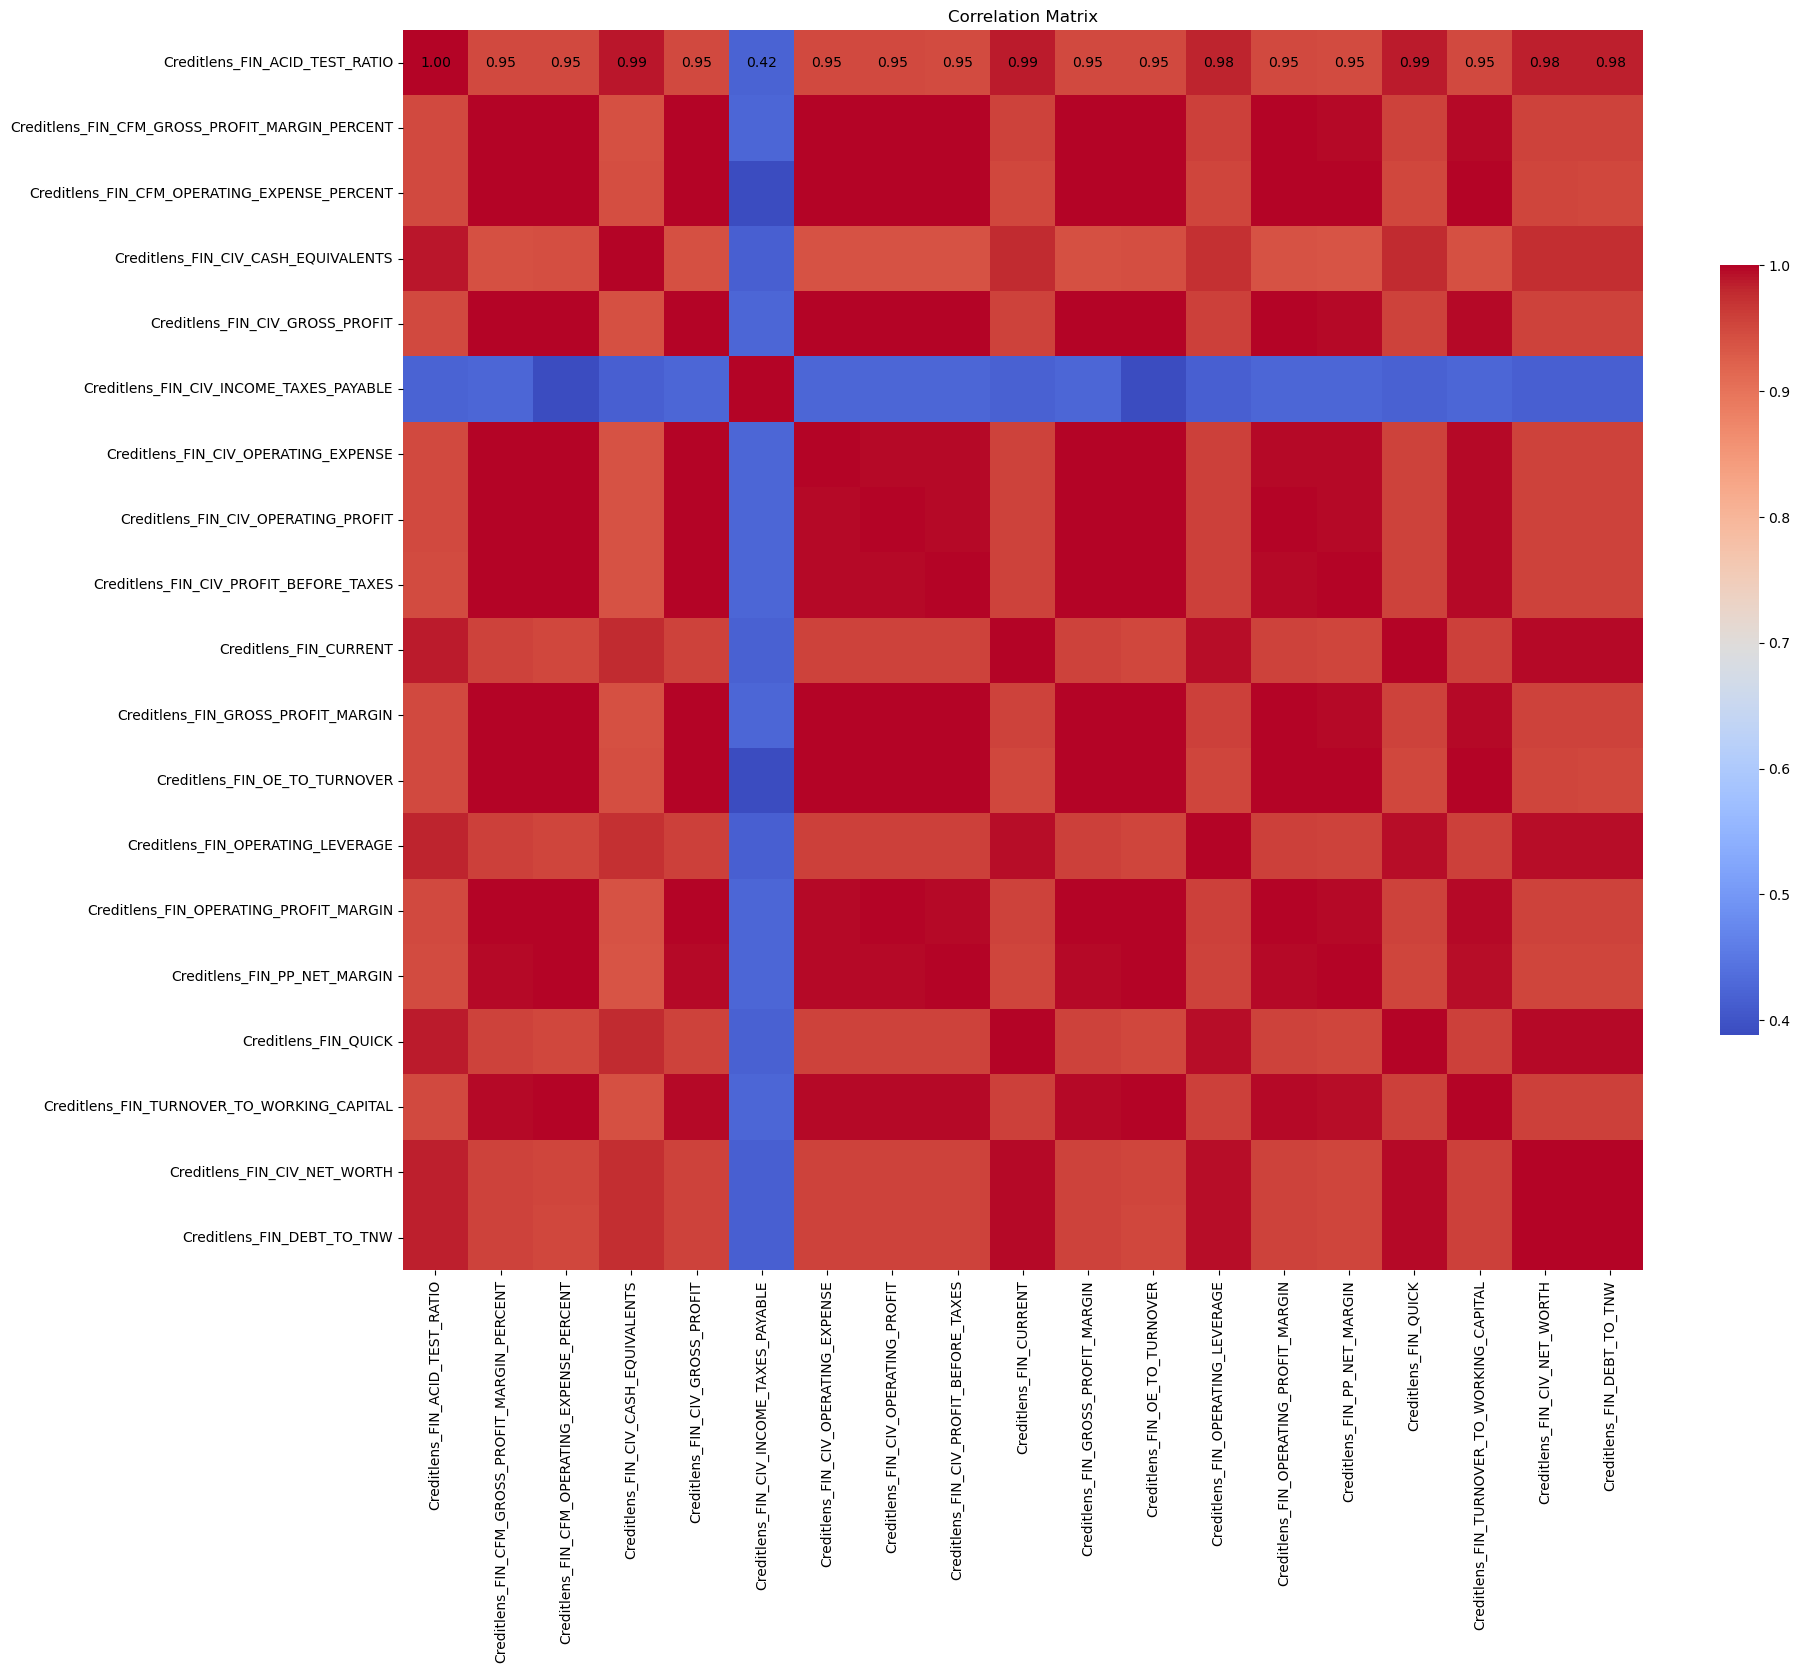

/Users/jellyma/miniforge3/envs/sklearn-env/lib/python3.12/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


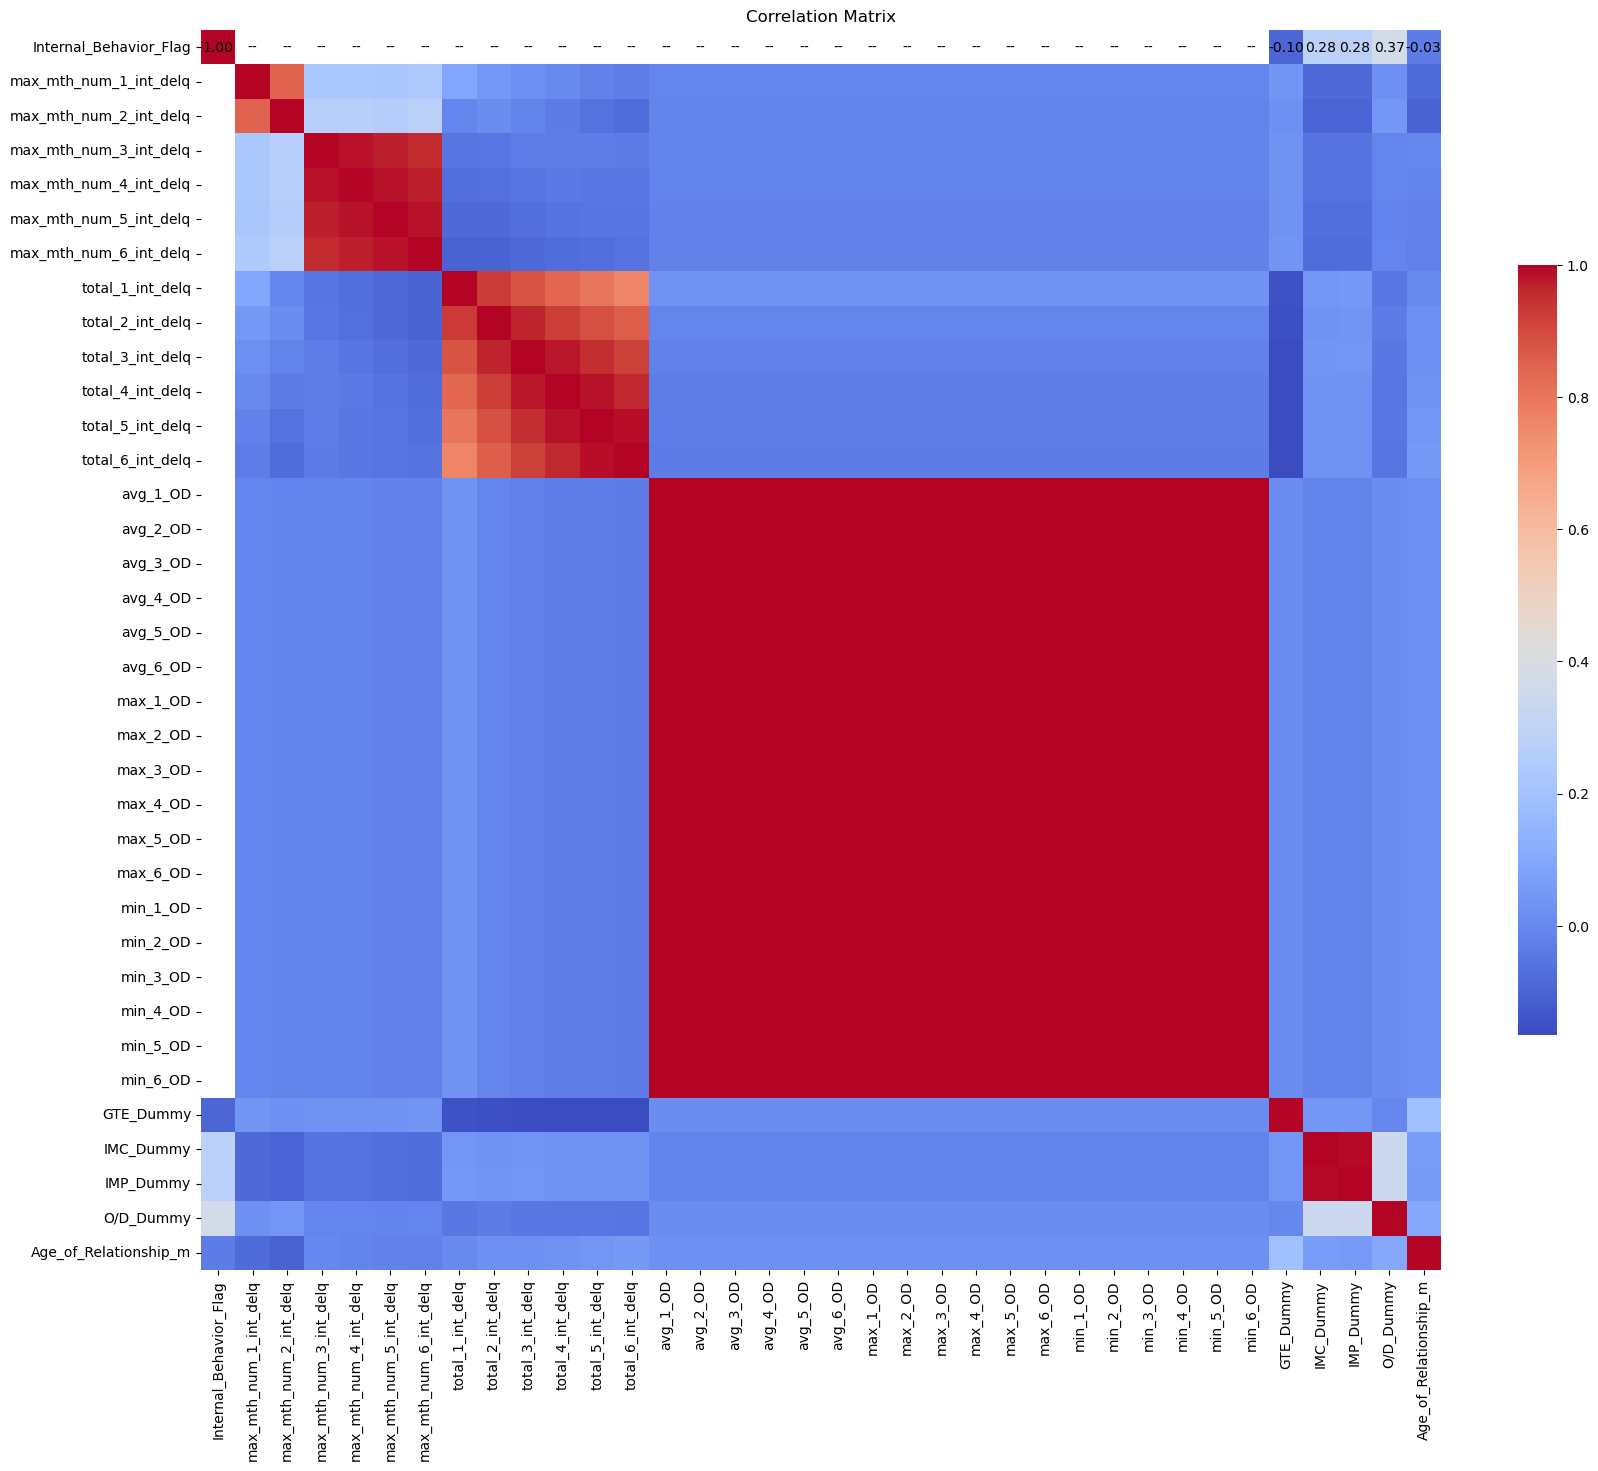

/Users/jellyma/miniforge3/envs/sklearn-env/lib/python3.12/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


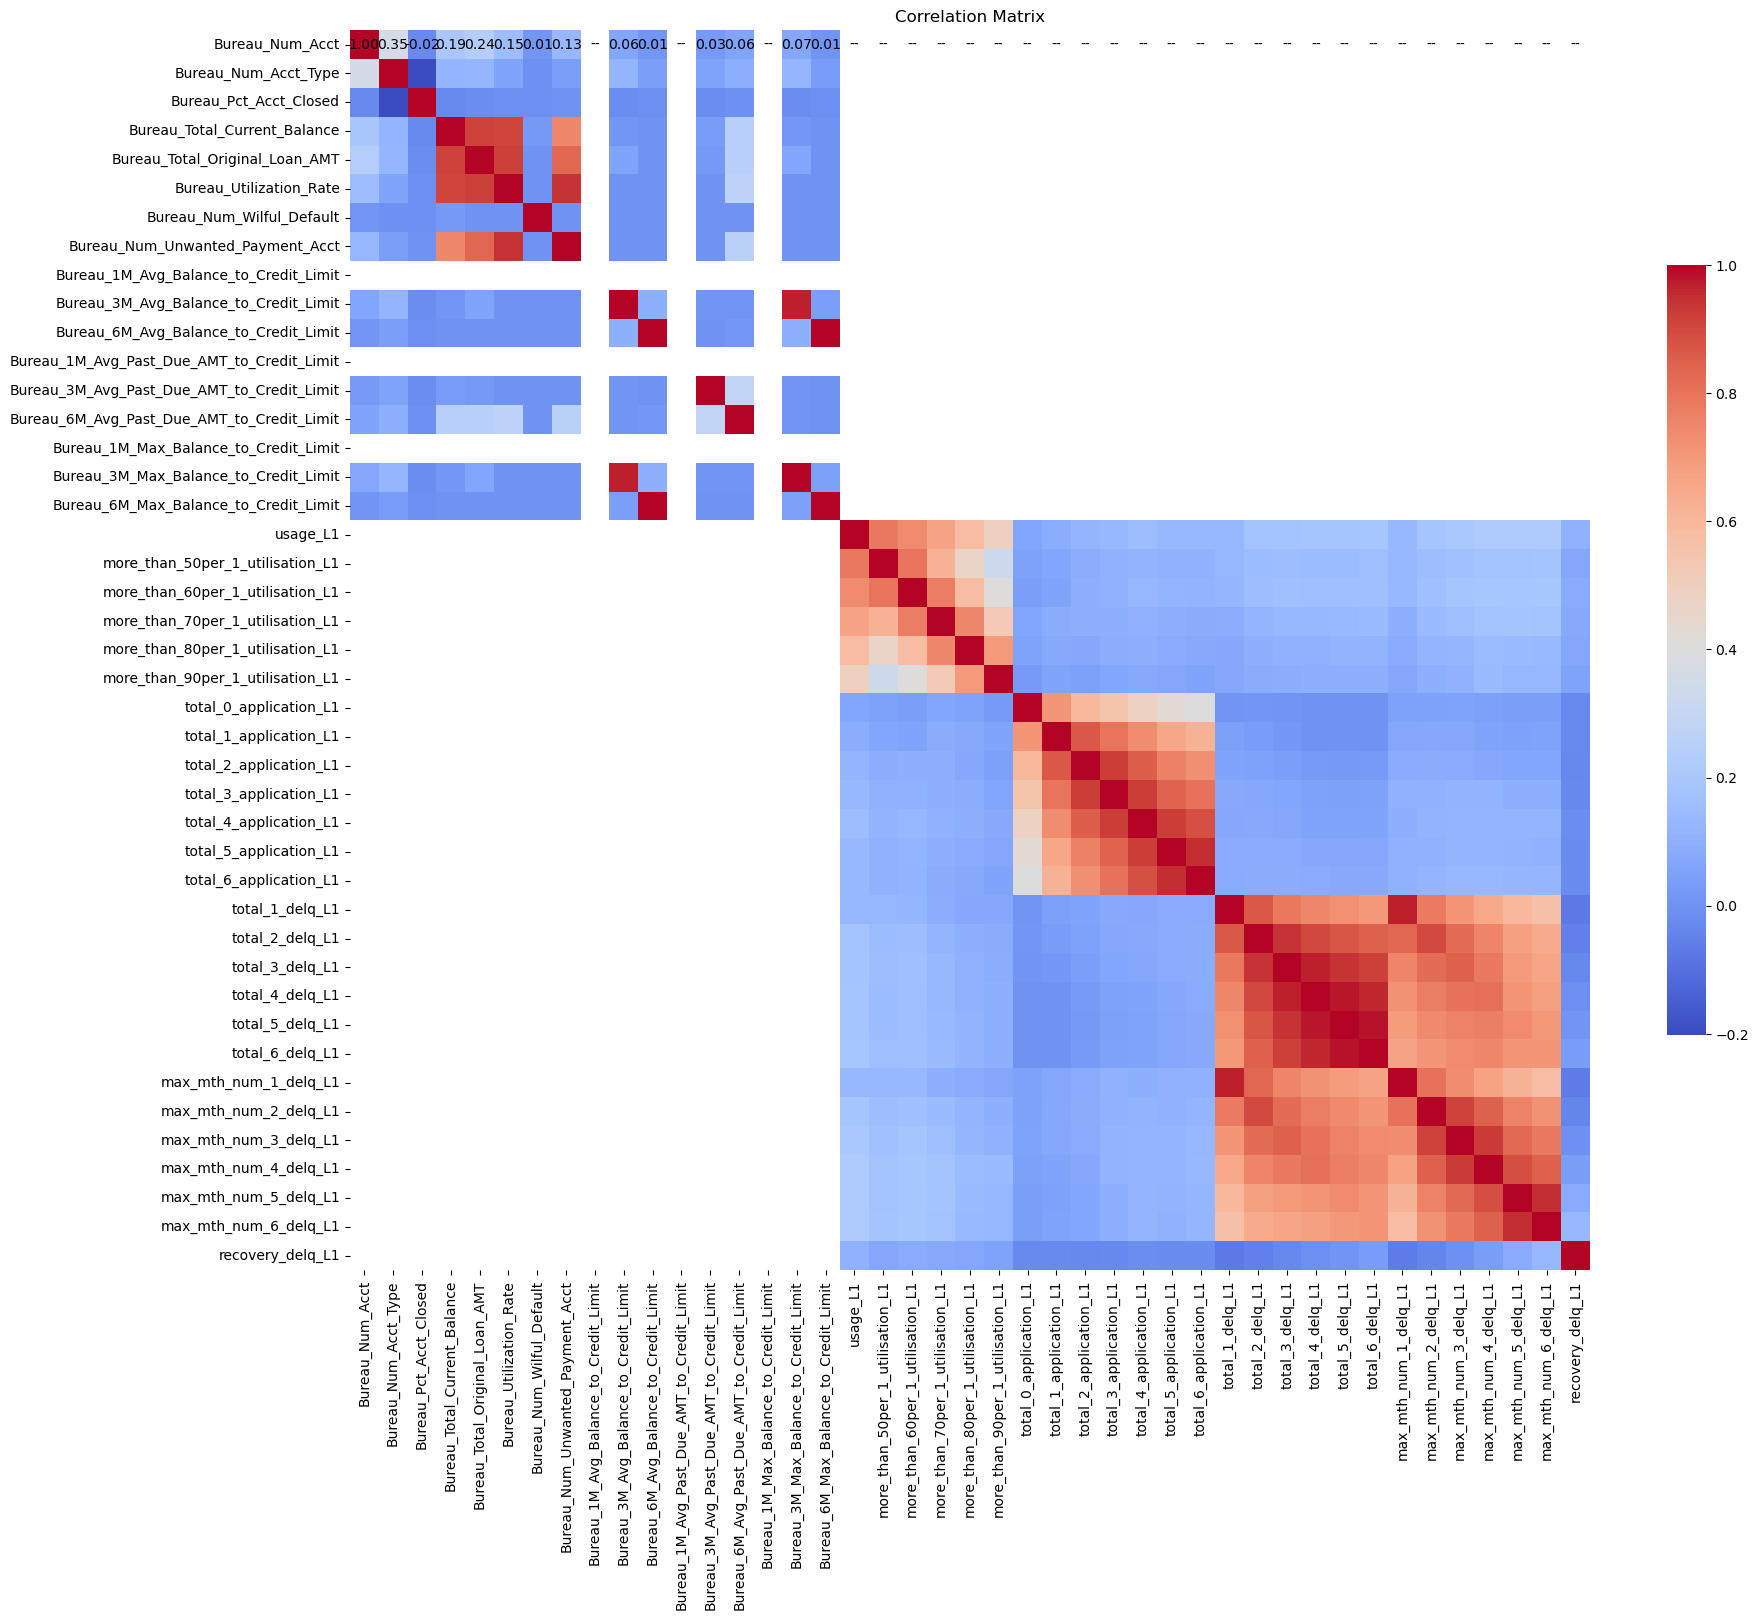

In [29]:
for feature_group in [financial_variables, internal_behavior_variables, bureau_variables]:
    # 计算相关系数矩阵
    corr_matrix = df[feature_group].corr()

    # 设置较大的图尺寸以便显示更多的特征
    plt.figure(figsize=(20, 20))  # 根据特征数量和显示需求调整这里的尺寸

    # 使用Seaborn绘制热图
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .5},
                square=True, annot_kws={'size': 10, "color": "black"})  # 调整annot_kws中的'size'以适应文本大小
    
    plt.title('Correlation Matrix')
    plt.show()


# Modeling

In [30]:
# 分层划分训练集和测试集
y = df['ModelChoice_Default_Flag']
X = df.drop(['ModelChoice_Default_Flag'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df[['ModelChoice_Default_Flag', 'Segment2']])# 初始化缩放器


## Baseline

In [73]:
X_train_baseline_encoded = pd.get_dummies(X_train[baseline_var], drop_first=True)

In [78]:
def objective(trial):
    # 为XGBoost定义超参数搜索空间
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'tree_method': 'exact',  # 可以设置为 'hist' 或 'gpu_hist'（如果使用GPU）
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0]),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    # 五折交叉验证
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc = []

    for train_index, test_index in kf.split(X_train_baseline_encoded, y_train):
        train_X, valid_X = X_train_baseline_encoded.iloc[train_index], X_train_baseline_encoded.iloc[test_index]
        train_y, valid_y = y_train.iloc[train_index], y_train.iloc[test_index]
        
        # 创建和训练模型
        baseline = xgb.XGBClassifier(**param)
        baseline.fit(train_X, train_y, eval_metric='logloss')
        
        # 预测和评估
        preds = baseline.predict_proba(valid_X)[:, 1]
        roc_auc.append(roc_auc_score(valid_y, preds))
    
    # 返回五折平均ROC AUC
    return sum(roc_auc) / len(roc_auc)

# 创建Optuna研究对象，开始调优
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 输出最优参数
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-04-18 21:58:10,716] A new study created in memory with name: no-name-29f4930d-4acd-43a3-a762-8b002262b15c
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/1857322788.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/1857322788.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/1857322788.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https

Best trial:
  Value: 0.7536430013345061
  Params: 
    lambda: 0.0032228901477640557
    alpha: 0.99881182610181
    colsample_bytree: 0.7
    subsample: 0.9
    learning_rate: 0.019557929713551303
    n_estimators: 342
    max_depth: 8
    min_child_weight: 1


### Test

In [79]:
X_test_baseline_encoded = pd.get_dummies(X_test[baseline_var], drop_first=True)

In [80]:
# 使用study.best_trial.params来获取最佳参数
best_params = study.best_trial.params

# 创建一个新的模型实例，使用最佳参数
baseline = xgb.XGBClassifier(**best_params, objective='binary:logistic', verbosity=0)

# 训练模型，这里使用整个训练数据集
baseline.fit(X_train_baseline_encoded, y_train, eval_metric='logloss')

# 预测测试集的概率
preds_proba = baseline.predict_proba(X_test_baseline_encoded)[:, 1]

# 计算并打印ROC AUC分数
roc_auc = roc_auc_score(y_test, preds_proba)
print(f'Test ROC AUC: {roc_auc:.4f}')
print()

/Users/jellyma/miniforge3/envs/sklearn-env/lib/python3.12/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Test ROC AUC: 0.7849


In [83]:
y_pred_baseline = baseline.predict(X_test_baseline_encoded)

# 评估模型
print(classification_report(y_test, y_pred_baseline))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2740
           1       0.57      0.04      0.07       103

    accuracy                           0.96      2843
   macro avg       0.77      0.52      0.53      2843
weighted avg       0.95      0.96      0.95      2843



## Model 1

### Modular: XGBoost

In [32]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [33]:
val_list = [financial_variables, internal_behavior_variables, bureau_variables]
best_params_list = []
model_list = []
for i in range(3):
    X_train_used = X_train_ros[val_list[i]]
    def objective(trial):
        # 超参数搜索范围
        param = {
            'verbosity': 0,
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 9),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10)  # 加权处理类不平衡
        }

        # 定义模型
        model = xgb.XGBClassifier(**param)

        # 使用交叉验证计算得分
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X_train_used, y_train_ros, cv=kf, scoring='roc_auc')

        # 最大化平均准确率
        return scores.mean()

    # 创建study对象
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    # 打印最佳试验结果
    print(f"Best trial accuracy: {study.best_trial.value}")
    print("Best params: ", study.best_trial.params)

    # 使用最佳参数重新训练模型
    best_params_list.append(study.best_trial.params)
    model = xgb.XGBClassifier(**study.best_trial.params)
    model.fit(X_train_used, y_train_ros)
    model_list.append(model)

[I 2024-04-17 01:13:25,299] A new study created in memory with name: no-name-acb83741-f76b-4ee0-95e0-174141d4037b


/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/77355500.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/77355500.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/77355500.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg

Best trial accuracy: 0.9876431809312823
Best params:  {'learning_rate': 0.2534567807233048, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9567319559515101, 'colsample_bytree': 0.6161805883789357, 'reg_alpha': 0.0005492905381328659, 'reg_lambda': 0.00010572746685903628, 'scale_pos_weight': 9.130640471287647}


[I 2024-04-17 01:29:36,474] A new study created in memory with name: no-name-1d1662e5-3b40-4b85-9475-6554638638a1
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/77355500.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/77355500.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/77355500.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in 

Best trial accuracy: 0.9775189930620147
Best params:  {'learning_rate': 0.1948660058627304, 'n_estimators': 282, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.8398448061626147, 'colsample_bytree': 0.9225883674026515, 'reg_alpha': 0.07556853838834618, 'reg_lambda': 0.03231986830015182, 'scale_pos_weight': 8.828664143250547}


[I 2024-04-17 03:17:41,947] A new study created in memory with name: no-name-30cb4e00-c5ee-46cd-bd91-cdc9093c1b93
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/77355500.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/77355500.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/77355500.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in 

Best trial accuracy: 0.8723835677105793
Best params:  {'learning_rate': 0.23147107704824346, 'n_estimators': 293, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.8257866666187529, 'colsample_bytree': 0.5293448783220456, 'reg_alpha': 0.000244589007582669, 'reg_lambda': 7.626533338343585e-05, 'scale_pos_weight': 8.451209978306872}


In [34]:
# the Probability as lable 1
for i in range(3):
    X_train_ros['modular'+str(i)] = model_list[i].predict_proba(X_train_ros[val_list[i]])[:, 1]

/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/1208970882.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_ros['modular'+str(i)] = model_list[i].predict_proba(X_train_ros[val_list[i]])[:, 1]
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/1208970882.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_ros['modular'+str(i)] = model_list[i].predict_proba(X_train_ros[val_list[i]])[:, 1]
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/1208970882.py:3: PerformanceW

In [35]:
X_train_ros.head()

,Site,Customer ID,Creditlens_FIN_ACID_TEST_RATIO,Creditlens_FIN_CFM_GROSS_PROFIT_MARGIN_PERCENT,Creditlens_FIN_CFM_OPERATING_EXPENSE_PERCENT,Creditlens_FIN_CIV_CASH_EQUIVALENTS,Creditlens_FIN_CIV_GROSS_PROFIT,Creditlens_FIN_CIV_INCOME_TAXES_PAYABLE,Creditlens_FIN_CIV_OPERATING_EXPENSE,Creditlens_FIN_CIV_OPERATING_PROFIT,...,max_mth_num_5_delq_L1,max_mth_num_6_delq_L1,recovery_delq_L1,Age_of_Company_in_Years,Age_Category,Segment,Segment2,modular0,modular1,modular2
0,AA,58280,1.739484,17.042837,7.974175,28.601071,22.186751,4.458664e+00,10.711527,16.374572,...,NaN,NaN,NaN,16.250000,10-20 years,AA_10-20 years_1_0_0,AA_1_0_0,0.000040,0.002184,0.022533
1,BB,59866,0.249934,23.253335,29.339910,1.145538,32.706195,1.000000e+11,34.224098,4.532100,...,1.0,1.0,0.0,35.583333,20-50 years,BB_20-50 years_1_0_0,BB_1_0_0,0.010192,0.000412,0.048822
2,VV,59276,1.139500,21.174103,NaN,40.614389,29.781722,2.400586e+00,27.769186,7.743764,...,NaN,NaN,NaN,10.000000,10-20 years,VV_10-20 years_0_1_0,VV_0_1_0,0.000049,0.000057,0.862521
3,VV,61229,0.929781,21.838887,NaN,21.480153,30.716751,5.434457e-01,37.583896,-0.928235,...,NaN,NaN,NaN,20.750000,20-50 years,VV_20-50 years_0_0_0,VV_0_0_0,0.000065,0.972740,0.862521
4,BB,54922,0.069234,-17.674537,22.851833,1.856631,-24.859524,1.000000e+11,47.520357,-70.689518,...,0.0,0.0,0.0,7.416667,6-10 years,BB_6-10 years_1_0_0,BB_1_0_0,0.000036,0.078703,0.000376


### Segment: Logistic

In [43]:
# 假设df是完整的DataFrame
segments = df['Segment2'].unique()  # 获取所有独特的segment

imputers_per_segment = {}  # 用于存储每个segment的KNNImputer
train_data = pd.concat([X_train_ros, y_train_ros], axis=1)
models_per_segment = {}

X_var_seg = ['Age_of_Company_in_Years', 'modular0', 'modular1', 'modular2']
for segment in segments:
    segment_data = train_data[train_data['Segment2'] == segment]

    # 分离特征和目标变量
    X_seg = segment_data.loc[:, X_var_seg]
    y_seg = segment_data['ModelChoice_Default_Flag']

    # 划分训练集和测试集
    X_train_seg, X_test_seg, y_train_seg, y_test_seg = train_test_split(X_seg, y_seg, test_size=0.2, random_state=42, stratify=segment_data['ModelChoice_Default_Flag'])

    # 填补缺失值
    knn_imputer = KNNImputer(n_neighbors=3)
    X_imputed_train = knn_imputer.fit_transform(X_train_seg)
    imputers_per_segment[segment] = knn_imputer  # 存储imputer

    # 创建逻辑回归模型
    model = LogisticRegression()
    model.fit(X_imputed_train, y_train_seg)  # 训练模型

    # 在测试集上评估模型
    X_imputed_test = knn_imputer.transform(X_test_seg)
    y_pred = model.predict(X_imputed_test)
    print(f"Segment - Classification Report:")
    print(classification_report(y_test_seg, y_pred))

    # 存储模型
    models_per_segment[segment] = model


Segment - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       303
           1       0.99      1.00      0.99       624

    accuracy                           0.99       927
   macro avg       0.99      0.99      0.99       927
weighted avg       0.99      0.99      0.99       927

Segment - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       165
           1       1.00      1.00      1.00       244

    accuracy                           1.00       409
   macro avg       1.00      1.00      1.00       409
weighted avg       1.00      1.00      1.00       409

Segment - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       171
           1       0.95      1.00      0.97       233

    accuracy                           0.97       404
   macro avg       0.97      

### Test

In [44]:
y_test_2 = y_test.copy()
X_test_2 = X_test.copy()

In [45]:
for i in range(3):
    X_test_2['modular'+str(i)] = model_list[i].predict_proba(X_test[val_list[i]])[:, 1]

In [46]:
# 假设 X_test, y_test 已经定义，且 X_test 包含一个名为 'Segment2' 的列用于识别数据段

# 初始化一个空的Series用于存储所有预测结果
y_pred_total = pd.Series(index=X_test_2.index, dtype='int')

# 对每个segment进行预处理和预测
for segment, model in models_per_segment.items():
    # 选出当前segment的测试数据
    segment_indices = X_test_2['Segment2'] == segment
    X_test_segment = X_test_2.loc[segment_indices, X_var_seg]  # 确保使用正确的特征变量列表

    # 应用KNNImputer
    imputer = imputers_per_segment[segment]
    X_imputed_ori_test = imputer.transform(X_test_segment)

    # 进行预测
    model = models_per_segment[segment]
    y_pred_segment = model.predict(X_imputed_ori_test)

    # 存储预测结果
    y_pred_total.loc[segment_indices] = y_pred_segment

# 评估模型
print(classification_report(y_test_2, y_pred_total))


              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2740
           1       0.08      0.07      0.08       103

    accuracy                           0.94      2843
   macro avg       0.52      0.52      0.52      2843
weighted avg       0.93      0.94      0.94      2843



In [50]:
print(classification_report(y_test_2, [1 if x > 0.5 else 0 for x in X_test_2['modular0']]))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90      2740
           1       0.07      0.34      0.12       103

    accuracy                           0.81      2843
   macro avg       0.52      0.59      0.51      2843
weighted avg       0.94      0.81      0.87      2843



In [51]:
print(classification_report(y_test_2, [1 if x > 0.5 else 0 for x in X_test_2['modular1']]))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90      2740
           1       0.04      0.20      0.07       103

    accuracy                           0.81      2843
   macro avg       0.51      0.52      0.49      2843
weighted avg       0.93      0.81      0.87      2843



In [52]:
print(classification_report(y_test_2, [1 if x > 0.5 else 0 for x in X_test_2['modular2']]))

              precision    recall  f1-score   support

           0       0.95      0.40      0.56      2740
           1       0.03      0.50      0.06       103

    accuracy                           0.40      2843
   macro avg       0.49      0.45      0.31      2843
weighted avg       0.92      0.40      0.54      2843



## Model 2：

### deal with outliers firstly

In [130]:
lower_quantile_segment = {}
upper_quantile_segment = {}
X_train_outlier = X_train.copy()

for module in [financial_variables, internal_behavior_variables, bureau_variables]:
    X = X_train_outlier[module].copy()
    X = X[abs(X) < 1e7]
    lower_quantile = X.quantile(0.001)
    upper_quantile = X.quantile(0.999)
    lower_quantile_segment['module'] = lower_quantile
    upper_quantile_segment['module'] = upper_quantile

    # 避免对0-1变量缩尾
    lower_quantile.loc[lower_quantile >= 0] = -1
    upper_quantile.loc[upper_quantile <= 1] = 2

    X = X.mask((X <= lower_quantile) | (X >= upper_quantile))
    X_train_outlier[module] = X

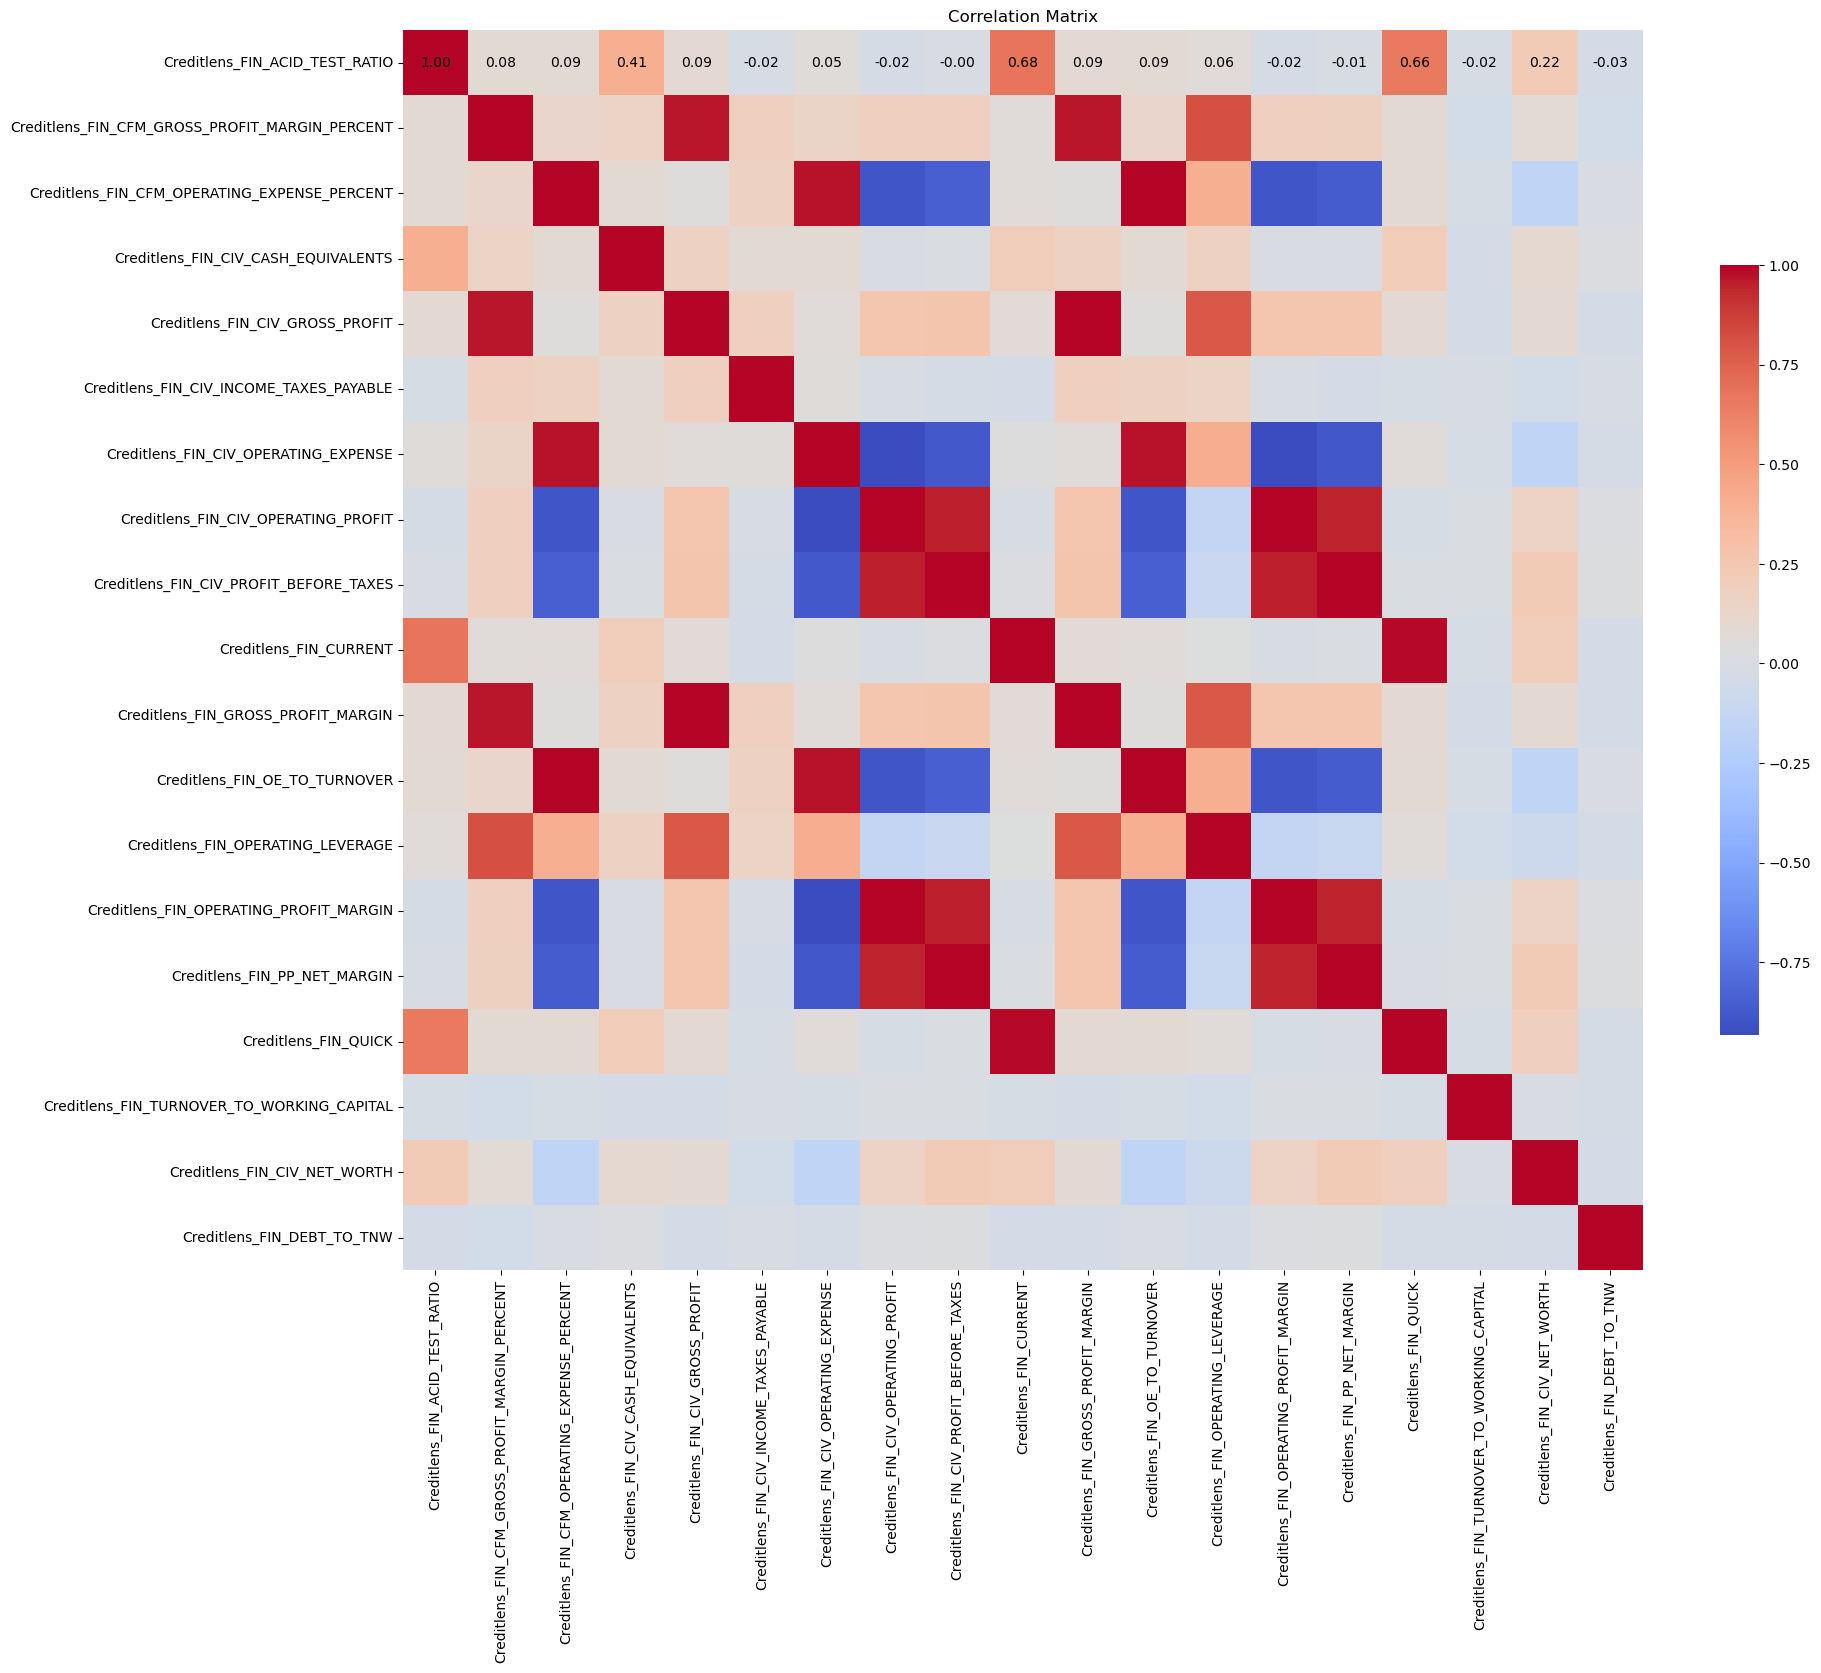

/Users/jellyma/miniforge3/envs/sklearn-env/lib/python3.12/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


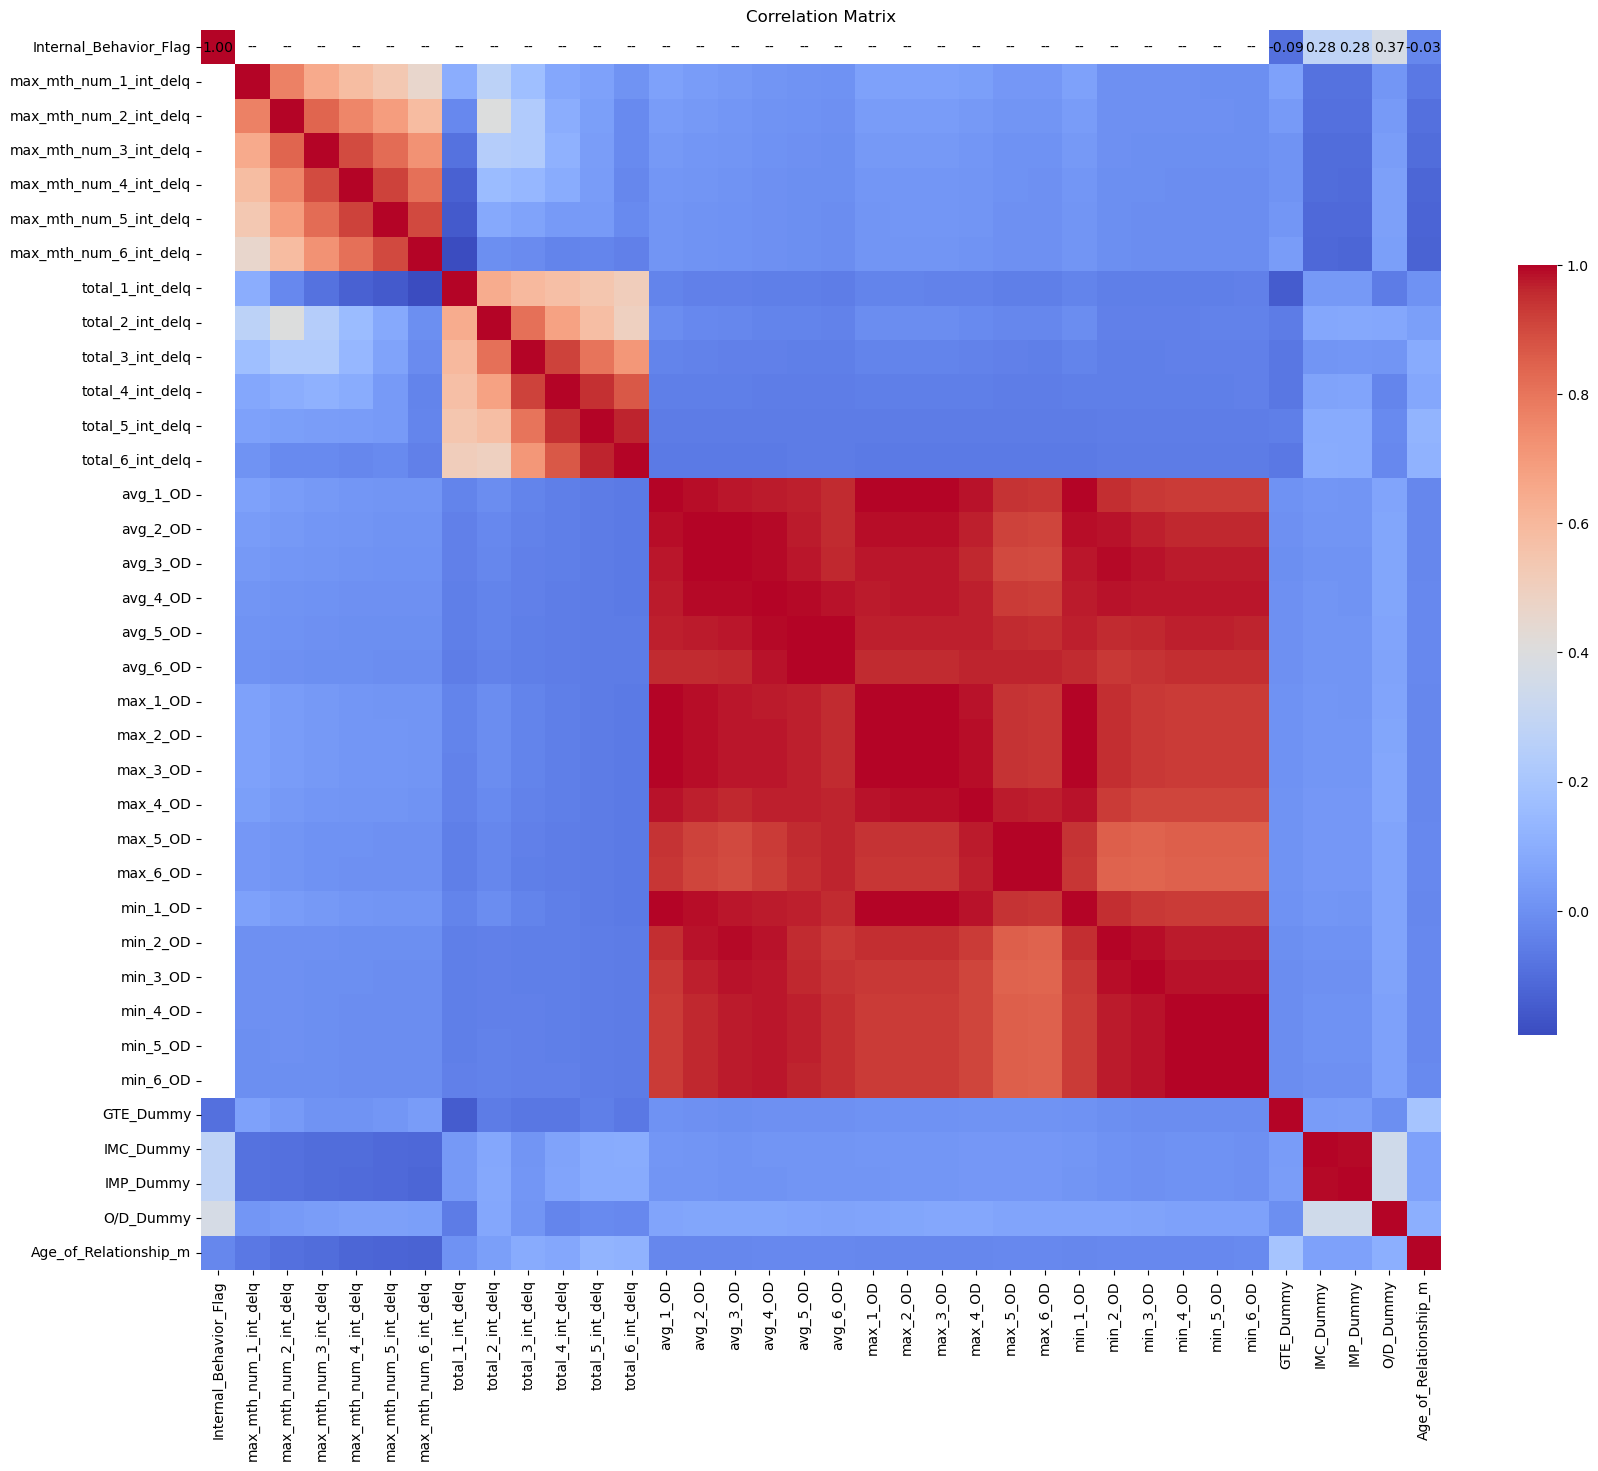

/Users/jellyma/miniforge3/envs/sklearn-env/lib/python3.12/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


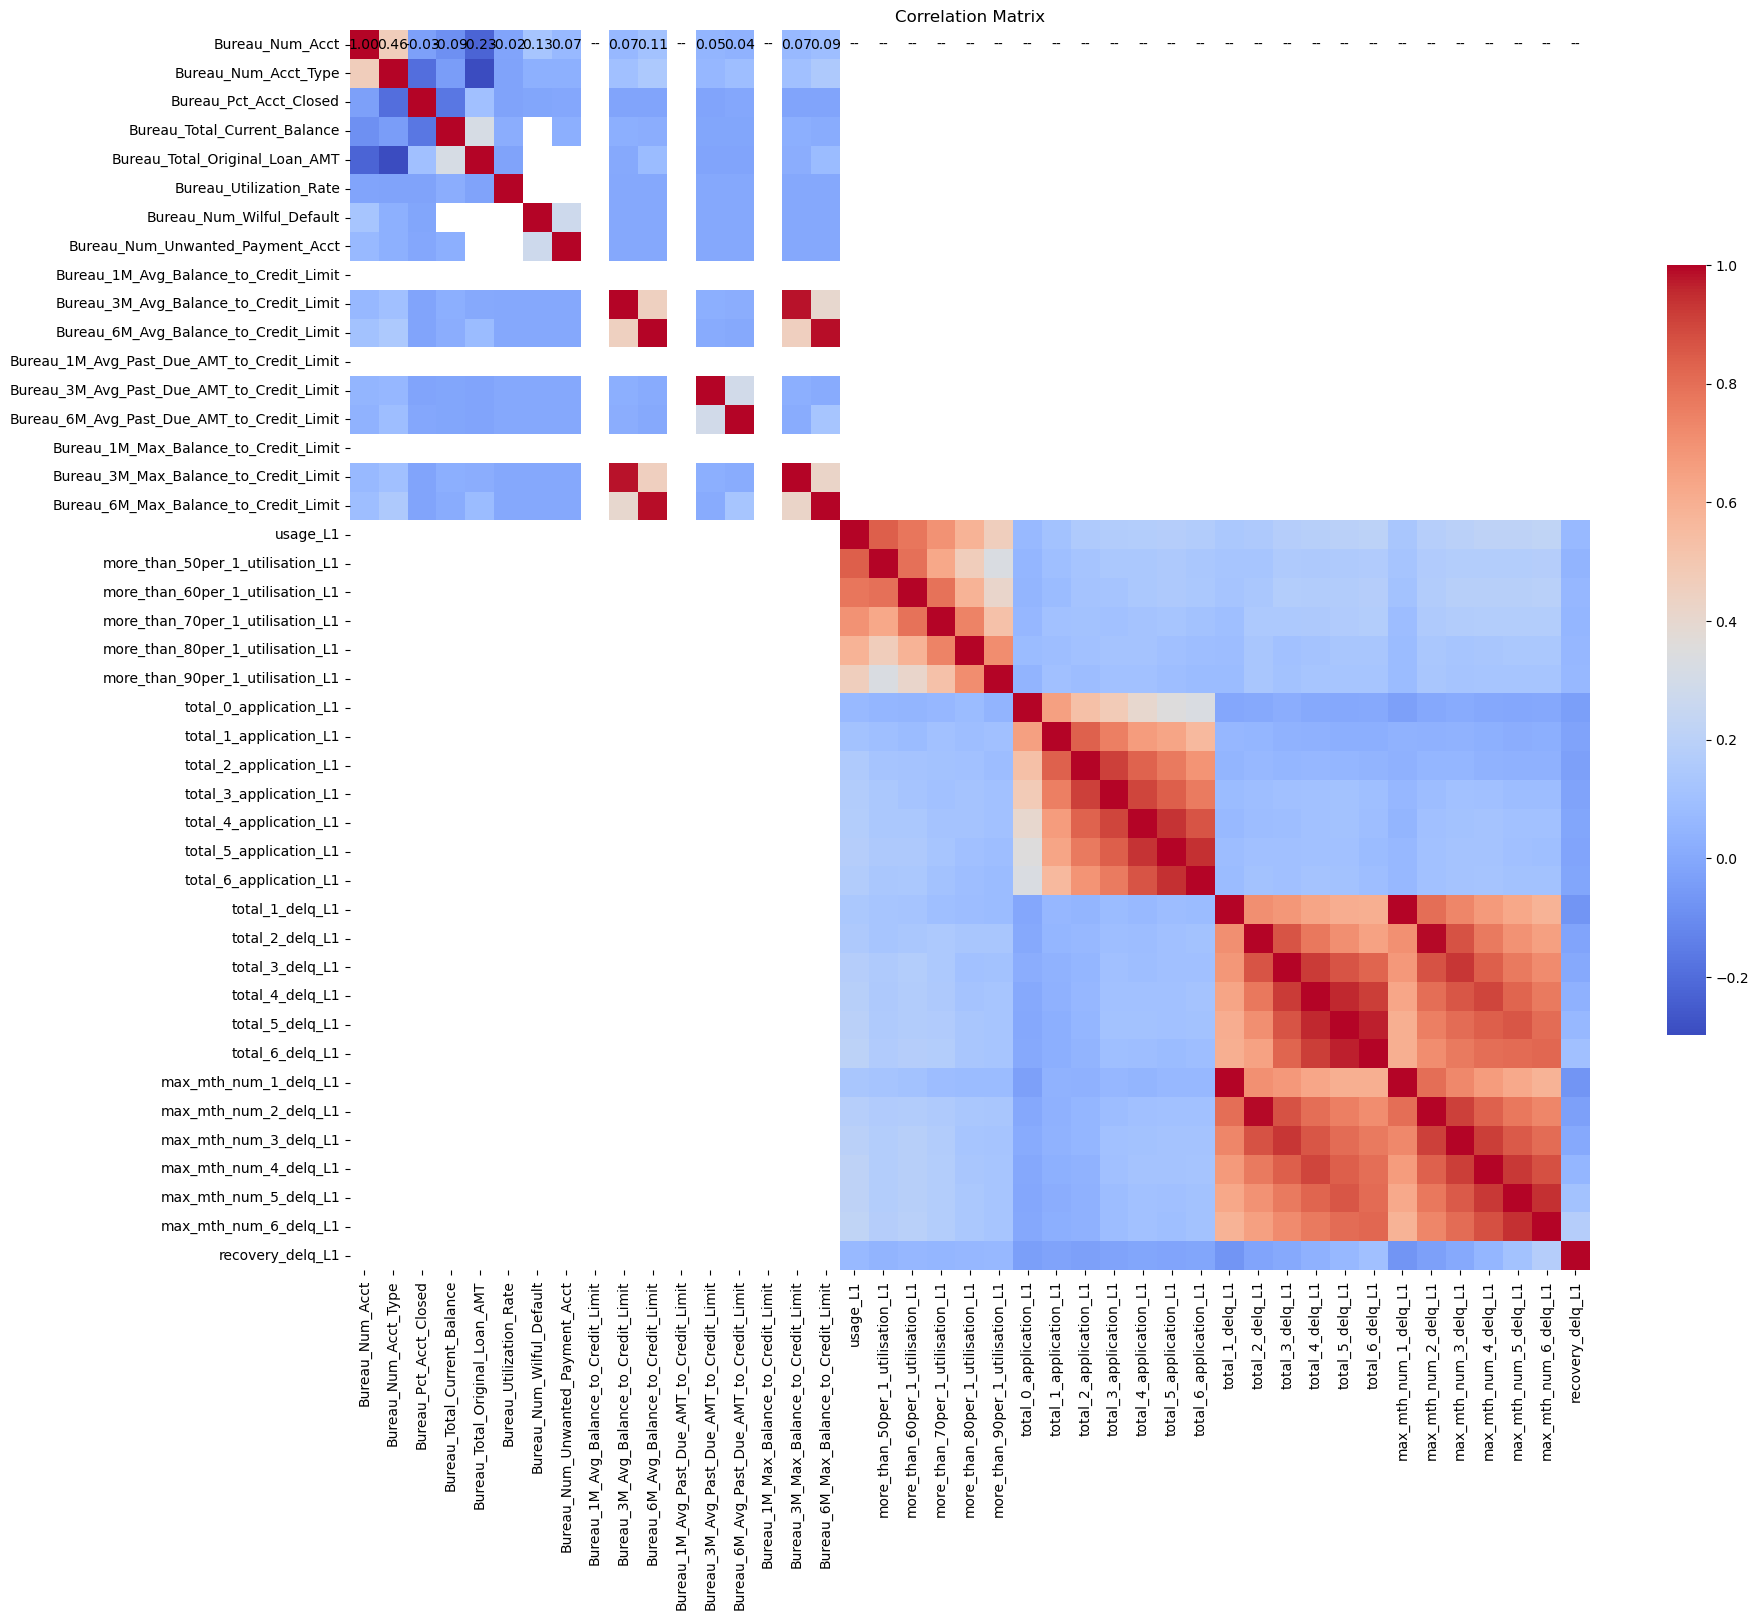

In [131]:
for feature_group in [financial_variables, internal_behavior_variables, bureau_variables]:
    # 计算相关系数矩阵
    corr_matrix = X_train_outlier[feature_group].corr()

    # 设置较大的图尺寸以便显示更多的特征
    plt.figure(figsize=(20, 20))  # 根据特征数量和显示需求调整这里的尺寸

    # 使用Seaborn绘制热图
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .5},
                square=True, annot_kws={'size': 10, "color": "black"})  # 调整annot_kws中的'size'以适应文本大小
    
    plt.title('Correlation Matrix')
    plt.show()


### Imputing Nan and Applying PCA

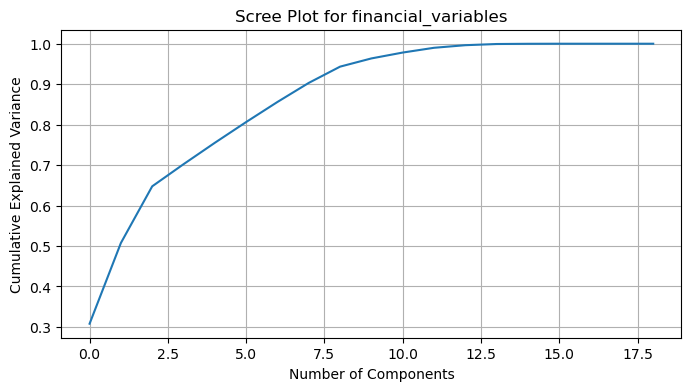

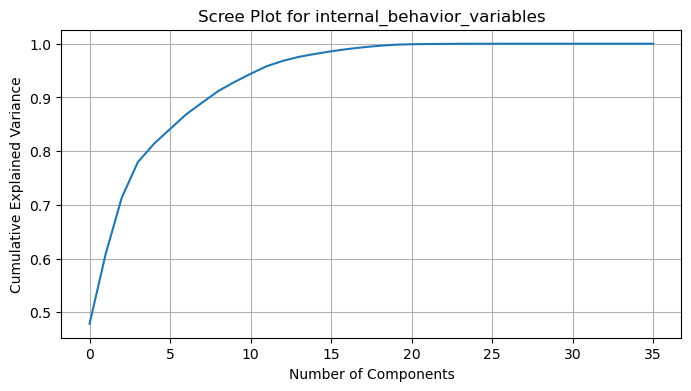

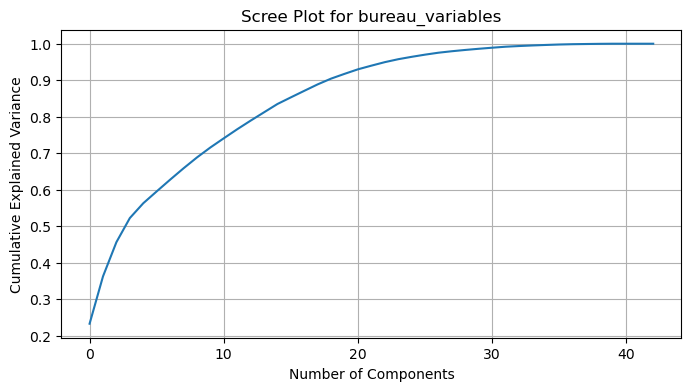

       Creditlens_FIN_ACID_TEST_RATIO  \
3572                         0.283182   
8404                        -0.437509   
10589                       -0.007109   
13427                       -0.108578   
9601                        -0.524938   
...                               ...   
5927                        -0.475252   
4068                        -0.374670   
8773                        -0.045873   
2215                        -0.471933   
5501                         0.000000   

       Creditlens_FIN_CFM_GROSS_PROFIT_MARGIN_PERCENT  \
3572                                        -0.130088   
8404                                         0.332392   
10589                                        0.177557   
13427                                        0.227062   
9601                                        -2.715401   
...                                               ...   
5927                                        -0.684680   
4068                                        -1.0627

In [103]:
modules = {
    'financial_variables': financial_variables,
    'internal_behavior_variables': internal_behavior_variables,
    'bureau_variables': bureau_variables
}

transformers = {}
processed_modules = {}
pca_models = {}

for module_name, variables in modules.items():
    # 初始化transformers字典为每个模块创建一个空字典
    transformers[module_name] = {}

    # 选择模块中的变量
    X = X_train_outlier[variables]
    
    # 分离出含缺失值和不含缺失值的列
    columns_with_na = X.columns[X.isna().any()]
    columns_without_na = X.columns[~X.isna().any()]
    
    if len(columns_with_na) > 0:
        # 对含缺失值的列进行归一化处理
        scaler_min_max = MinMaxScaler()
        X_normalized = scaler_min_max.fit_transform(X[columns_with_na])
        transformers[module_name]['scaler_min_max'] = scaler_min_max

        # 使用 KNNImputer 填充缺失值
        imputer = KNNImputer(n_neighbors=int(round(np.sqrt(len(variables)))))
        X_imputed = imputer.fit_transform(X_normalized)
        transformers[module_name]['imputer'] = imputer

        # 创建 DataFrame
        X_imputed_df = pd.DataFrame(X_imputed, columns=columns_with_na, index=X.index)
    else:
        # 如果没有缺失值的列，直接创建一个空的DataFrame
        X_imputed_df = pd.DataFrame(index=X.index)

    # 合并填补后的数据与原始无缺失值数据
    if len(columns_without_na) > 0:
        X_combined = pd.concat([X_imputed_df, X[columns_without_na]], axis=1)
    else:
        X_combined = X_imputed_df

    # 标准化处理
    scaler_std = StandardScaler()
    X_standardized = scaler_std.fit_transform(X_combined)
    transformers[module_name]['scaler_std'] = scaler_std

    # 存储处理后的数据
    processed_modules[module_name] = pd.DataFrame(X_standardized, columns=X_combined.columns, index=X.index)

    # 应用PCA
    pca = PCA()
    pca.fit(X_standardized)
    pca_models[module_name] = pca

    # 绘制崖底随石图
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'Scree Plot for {module_name}')
    plt.grid(True)
    plt.show()
    
    # 存储每个模块的PCA模型和变换器
    transformers[module_name]['pca'] = pca

# 合并处理后的模块数据
X_train_imputed = pd.concat(processed_modules.values(), axis=1)
print(X_train_imputed)

In [109]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_components = {
    'financial_variables': 10,
    'internal_behavior_variables': 15,
    'bureau_variables': 25
}

# 对每个模块应用新的PCA
for module_name, components in pca_components.items():

    X_scaled = processed_modules[module_name]
    
    # 应用新的PCA
    pca = PCA(n_components=components)
    X_pca = pca.fit_transform(X_scaled)
    
    # 保存新的PCA模型
    transformers[module_name]['pca'] = pca

    # 保存PCA变换后的数据
    pca_columns = [f'PC{i+1}' for i in range(components)]
    processed_modules[module_name] = pd.DataFrame(X_pca, columns=pca_columns, index=processed_modules[module_name].index)

    # 打印出每个模块的PCA解释方差比例
    print(f'Explained Variance Ratio for {module_name}: {pca.explained_variance_ratio_}')

# 如果需要，可以将所有模块的数据合并为一个DataFrame
final_data = pd.concat(processed_modules.values(), axis=1)
print(final_data.head())


Explained Variance Ratio for financial_variables: [0.31957179 0.20710824 0.14532754 0.05670357 0.05490949 0.05321563
 0.05151364 0.04890236 0.04166775 0.02108   ]
Explained Variance Ratio for internal_behavior_variables: [0.48812034 0.13244693 0.10690532 0.06730516 0.03479075 0.02807767
 0.02773457 0.02250869 0.02186194 0.01706044 0.01548313 0.01445765
 0.0100885  0.00764826 0.00551065]
Explained Variance Ratio for bureau_variables: [0.24152993 0.1345619  0.0972982  0.0684418  0.04207196 0.03367633
 0.03325081 0.03233989 0.03086092 0.0283199  0.02613164 0.02567758
 0.02449912 0.02369661 0.02360795 0.01886328 0.01858093 0.01837518
 0.0163646  0.01348525 0.0129018  0.01039011 0.00994704 0.00835353
 0.00677375]
            PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
3572  -0.658044  0.287538  0.588935  0.956769  1.693695 -0.624322  0.553217   
8404  -0.268214 -0.427606 -0.840661 -0.450439 -0.196667  0.022732 -0.077038   
10589 -0.214568 -0.616533  0.102779  0.731027

In [106]:
X_train.head()

,Site,Customer ID,Creditlens_FIN_ACID_TEST_RATIO,Creditlens_FIN_CFM_GROSS_PROFIT_MARGIN_PERCENT,Creditlens_FIN_CFM_OPERATING_EXPENSE_PERCENT,Creditlens_FIN_CIV_CASH_EQUIVALENTS,Creditlens_FIN_CIV_GROSS_PROFIT,Creditlens_FIN_CIV_INCOME_TAXES_PAYABLE,Creditlens_FIN_CIV_OPERATING_EXPENSE,Creditlens_FIN_CIV_OPERATING_PROFIT,...,max_mth_num_2_delq_L1,max_mth_num_3_delq_L1,max_mth_num_4_delq_L1,max_mth_num_5_delq_L1,max_mth_num_6_delq_L1,recovery_delq_L1,Age_of_Company_in_Years,Age_Category,Segment,Segment2
3572,AA,58280,1.739484,17.042837,7.974175,28.601071,22.186751,4.458664e+00,10.711527,16.374572,...,NaN,NaN,NaN,NaN,NaN,NaN,16.250000,10-20 years,AA_10-20 years_1_0_0,AA_1_0_0
8404,BB,59866,0.249934,23.253335,29.339910,1.145538,32.706195,1.000000e+11,34.224098,4.532100,...,1.0,1.0,1.0,1.0,1.0,0.0,35.583333,20-50 years,BB_20-50 years_1_0_0,BB_1_0_0
10589,VV,59276,1.139500,21.174103,NaN,40.614389,29.781722,2.400586e+00,27.769186,7.743764,...,NaN,NaN,NaN,NaN,NaN,NaN,10.000000,10-20 years,VV_10-20 years_0_1_0,VV_0_1_0
13427,VV,61229,0.929781,21.838887,NaN,21.480153,30.716751,5.434457e-01,37.583896,-0.928235,...,NaN,NaN,NaN,NaN,NaN,NaN,20.750000,20-50 years,VV_20-50 years_0_0_0,VV_0_0_0
9601,BB,54922,0.069234,-17.674537,22.851833,1.856631,-24.859524,1.000000e+11,47.520357,-70.689518,...,0.0,0.0,0.0,0.0,0.0,0.0,7.416667,6-10 years,BB_6-10 years_1_0_0,BB_1_0_0


In [110]:
final_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
3572,-0.658044,0.287538,0.588935,0.956769,1.693695,-0.624322,0.553217,-0.221906,0.571872,0.069249,...,-7.114904e-01,7.908338e-01,2.186135e-01,9.513882e-14,9.614743e-14,2.260889e-01,-9.719701e-14,1.241449e-14,-1.866984e-02,-1.225772e-14
8404,-0.268214,-0.427606,-0.840661,-0.450439,-0.196667,0.022732,-0.077038,0.741581,0.244460,-0.109514,...,3.998883e-14,-8.066679e-14,-4.125020e-14,7.603331e+00,-1.564671e-01,3.377615e-15,1.750228e-01,3.122776e+00,1.405474e-14,6.126154e-01
10589,-0.214568,-0.616533,0.102779,0.731027,0.910052,-0.272540,-0.233996,-1.180616,-0.076203,0.502054,...,3.061104e-14,1.247366e-14,2.724069e-14,1.190229e-14,-2.961887e-14,-4.399455e-14,-9.792026e-14,2.684354e-13,-1.147686e-14,7.514625e-14
13427,-0.103225,-0.556788,-0.172270,-0.153230,-0.371894,-0.042208,-0.660034,-0.435438,-0.001667,0.205917,...,2.319497e-14,-1.134237e-14,6.736607e-14,7.825885e-15,2.736661e-15,-4.540185e-14,1.731638e-14,-2.367039e-14,-8.747555e-14,4.229861e-15
9601,0.856812,4.221797,-0.139798,1.273750,-0.293939,0.909342,0.373229,0.539056,-0.211994,-0.022623,...,-7.430628e-14,-2.513507e-15,1.127071e-13,-8.667614e-02,2.853930e-01,-5.798096e-14,5.851837e-01,-2.652947e+00,-5.409414e-14,-3.930151e-01


In [111]:
# columns_to_segment_by_2是包含列名的列表，这些列的信息要加入到final_data中
# 从X_train_outlier选择这些列
Age_col = ['Age_Category', 'Age_of_Company_in_Years']
additional_columns = X_train_outlier[columns_to_segment_by_2 + Age_col]

# 将这些列合并到final_data中，确保沿列方向合并(axis=1)
final_data = pd.concat([final_data, additional_columns], axis=1)

# 查看合并后的数据
final_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC22,PC23,PC24,PC25,Site,Industry_Manufacturing_Flag,Industry_Wholesale_Trade_Flag,Industry_Services_Flag,Age_Category,Age_of_Company_in_Years
3572,-0.658044,0.287538,0.588935,0.956769,1.693695,-0.624322,0.553217,-0.221906,0.571872,0.069249,...,-9.719701e-14,1.241449e-14,-1.866984e-02,-1.225772e-14,AA,1,0,0,10-20 years,16.250000
8404,-0.268214,-0.427606,-0.840661,-0.450439,-0.196667,0.022732,-0.077038,0.741581,0.244460,-0.109514,...,1.750228e-01,3.122776e+00,1.405474e-14,6.126154e-01,BB,1,0,0,20-50 years,35.583333
10589,-0.214568,-0.616533,0.102779,0.731027,0.910052,-0.272540,-0.233996,-1.180616,-0.076203,0.502054,...,-9.792026e-14,2.684354e-13,-1.147686e-14,7.514625e-14,VV,0,1,0,10-20 years,10.000000
13427,-0.103225,-0.556788,-0.172270,-0.153230,-0.371894,-0.042208,-0.660034,-0.435438,-0.001667,0.205917,...,1.731638e-14,-2.367039e-14,-8.747555e-14,4.229861e-15,VV,0,0,0,20-50 years,20.750000
9601,0.856812,4.221797,-0.139798,1.273750,-0.293939,0.909342,0.373229,0.539056,-0.211994,-0.022623,...,5.851837e-01,-2.652947e+00,-5.409414e-14,-3.930151e-01,BB,1,0,0,6-10 years,7.416667


### Modular: XGBoost

In [113]:
final_data.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC1', 'PC2', 'PC3', 'PC4',
       'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13',
       'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22',
       'PC23', 'PC24', 'PC25', 'Site', 'Industry_Manufacturing_Flag',
       'Industry_Wholesale_Trade_Flag', 'Industry_Services_Flag',
       'Age_Category', 'Age_of_Company_in_Years'],
      dtype='object')

In [117]:
# 定义每组变量的PCA主成分数
pca_counts = {
    'financial': 10,
    'internal_behavior': 15,
    'bureau': 25
}

# 开始构建新的列名列表
new_column_names = []

# 追踪当前PCA主成分的起始位置
start_index = 0

# 对每组变量进行循环
for group_name, count in pca_counts.items():
    # 为每个主成分生成新的列名，格式为"group_name_PCX"
    new_column_names.extend([f'{group_name}_PC{i+1}' for i in range(count)])
    # 更新起始索引位置
    start_index += count

# 添加额外的非PCA列
additional_cols = ['Site', 'Industry_Manufacturing_Flag', 'Industry_Wholesale_Trade_Flag', 
                   'Industry_Services_Flag', 'Age_Category', 'Age_of_Company_in_Years']
new_column_names.extend(additional_cols)

# 确保新的列名列表长度与final_data的列数相同
assert len(new_column_names) == final_data.shape[1], "Column names list does not match DataFrame column count"

# 应用新的列名到final_data
final_data.columns = new_column_names

# 显示更新后的列名以验证
print(final_data.columns)

Index(['financial_PC1', 'financial_PC2', 'financial_PC3', 'financial_PC4',
       'financial_PC5', 'financial_PC6', 'financial_PC7', 'financial_PC8',
       'financial_PC9', 'financial_PC10', 'internal_behavior_PC1',
       'internal_behavior_PC2', 'internal_behavior_PC3',
       'internal_behavior_PC4', 'internal_behavior_PC5',
       'internal_behavior_PC6', 'internal_behavior_PC7',
       'internal_behavior_PC8', 'internal_behavior_PC9',
       'internal_behavior_PC10', 'internal_behavior_PC11',
       'internal_behavior_PC12', 'internal_behavior_PC13',
       'internal_behavior_PC14', 'internal_behavior_PC15', 'bureau_PC1',
       'bureau_PC2', 'bureau_PC3', 'bureau_PC4', 'bureau_PC5', 'bureau_PC6',
       'bureau_PC7', 'bureau_PC8', 'bureau_PC9', 'bureau_PC10', 'bureau_PC11',
       'bureau_PC12', 'bureau_PC13', 'bureau_PC14', 'bureau_PC15',
       'bureau_PC16', 'bureau_PC17', 'bureau_PC18', 'bureau_PC19',
       'bureau_PC20', 'bureau_PC21', 'bureau_PC22', 'bureau_PC23',
       

In [118]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(final_data, y_train)

In [119]:
financial_pca = ['financial_PC1', 'financial_PC2', 'financial_PC3', 'financial_PC4',
       'financial_PC5', 'financial_PC6', 'financial_PC7', 'financial_PC8',
       'financial_PC9', 'financial_PC10']
internal_behavior_pca = ['internal_behavior_PC1',
       'internal_behavior_PC2', 'internal_behavior_PC3',
       'internal_behavior_PC4', 'internal_behavior_PC5',
       'internal_behavior_PC6', 'internal_behavior_PC7',
       'internal_behavior_PC8', 'internal_behavior_PC9',
       'internal_behavior_PC10', 'internal_behavior_PC11',
       'internal_behavior_PC12', 'internal_behavior_PC13',
       'internal_behavior_PC14', 'internal_behavior_PC15']
bureau_pca = ['bureau_PC1',
       'bureau_PC2', 'bureau_PC3', 'bureau_PC4', 'bureau_PC5', 'bureau_PC6',
       'bureau_PC7', 'bureau_PC8', 'bureau_PC9', 'bureau_PC10', 'bureau_PC11',
       'bureau_PC12', 'bureau_PC13', 'bureau_PC14', 'bureau_PC15',
       'bureau_PC16', 'bureau_PC17', 'bureau_PC18', 'bureau_PC19',
       'bureau_PC20', 'bureau_PC21', 'bureau_PC22', 'bureau_PC23',
       'bureau_PC24', 'bureau_PC25']
val_list = [financial_pca, internal_behavior_pca, bureau_pca]
best_params_list = []
model_list = []
for i in range(3):
    X_train_used = X_train_ros[val_list[i]]
    def objective(trial):
        # 超参数搜索范围
        param = {
            'verbosity': 0,
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 9),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10)  # 加权处理类不平衡
        }

        # 定义模型
        model = xgb.XGBClassifier(**param)

        # 使用交叉验证计算得分
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X_train_used, y_train_ros, cv=kf, scoring='roc_auc')

        # 最大化平均准确率
        return scores.mean()

    # 创建study对象
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    # 打印最佳试验结果
    print(f"Best trial accuracy: {study.best_trial.value}")
    print("Best params: ", study.best_trial.params)

    # 使用最佳参数重新训练模型
    best_params_list.append(study.best_trial.params)
    model = xgb.XGBClassifier(**study.best_trial.params)
    model.fit(X_train_used, y_train_ros)
    model_list.append(model)

[I 2024-04-19 11:38:52,461] A new study created in memory with name: no-name-77190575-f165-447e-8dd1-65097976bbbb
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/1986785071.py:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/1986785071.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/1986785071.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remov

Best trial accuracy: 0.9855084740704433
Best params:  {'learning_rate': 0.13821656160049, 'n_estimators': 256, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.5375238546577391, 'colsample_bytree': 0.526217700573746, 'reg_alpha': 0.16786687985955892, 'reg_lambda': 0.0379509099900512, 'scale_pos_weight': 7.302647650517122}


[I 2024-04-19 11:50:05,807] A new study created in memory with name: no-name-9ebf92c5-fb6c-4732-9c5f-e5f8b80a3753
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/1986785071.py:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/1986785071.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/1986785071.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remov

Best trial accuracy: 0.9774317834792239
Best params:  {'learning_rate': 0.19882047401786115, 'n_estimators': 274, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9575041432876602, 'colsample_bytree': 0.6229232735591816, 'reg_alpha': 0.500682216284424, 'reg_lambda': 0.02960921717399437, 'scale_pos_weight': 7.092649146523912}


[I 2024-04-19 12:06:55,586] A new study created in memory with name: no-name-387b9e10-871e-4a20-a45f-9f8e0b9290d7
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/1986785071.py:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/1986785071.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/var/folders/96/jgt7hkqx32dgxbtj_c9vymc80000gn/T/ipykernel_10301/1986785071.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remov

Best trial accuracy: 0.8525103154355806
Best params:  {'learning_rate': 0.23666029874481195, 'n_estimators': 226, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.7998227444785366, 'colsample_bytree': 0.6562700870816702, 'reg_alpha': 2.4344239482900032e-05, 'reg_lambda': 0.01421467050317384, 'scale_pos_weight': 9.672482867738028}


In [120]:
# the Probability as lable 1
for i in range(3):
    X_train_ros['modular'+str(i)] = model_list[i].predict_proba(X_train_ros[val_list[i]])[:, 1]

In [121]:
X_train_ros.head()

,financial_PC1,financial_PC2,financial_PC3,financial_PC4,financial_PC5,financial_PC6,financial_PC7,financial_PC8,financial_PC9,financial_PC10,...,bureau_PC25,Site,Industry_Manufacturing_Flag,Industry_Wholesale_Trade_Flag,Industry_Services_Flag,Age_Category,Age_of_Company_in_Years,modular0,modular1,modular2
0,-0.658044,0.287538,0.588935,0.956769,1.693695,-0.624322,0.553217,-0.221906,0.571872,0.069249,...,-1.225772e-14,AA,1,0,0,10-20 years,16.250000,0.000058,0.009307,0.000220
1,-0.268214,-0.427606,-0.840661,-0.450439,-0.196667,0.022732,-0.077038,0.741581,0.244460,-0.109514,...,6.126154e-01,BB,1,0,0,20-50 years,35.583333,0.004510,0.032798,0.020660
2,-0.214568,-0.616533,0.102779,0.731027,0.910052,-0.272540,-0.233996,-1.180616,-0.076203,0.502054,...,7.514625e-14,VV,0,1,0,10-20 years,10.000000,0.000128,0.000120,0.008575
3,-0.103225,-0.556788,-0.172270,-0.153230,-0.371894,-0.042208,-0.660034,-0.435438,-0.001667,0.205917,...,4.229861e-15,VV,0,0,0,20-50 years,20.750000,0.003685,0.967946,0.005900
4,0.856812,4.221797,-0.139798,1.273750,-0.293939,0.909342,0.373229,0.539056,-0.211994,-0.022623,...,-3.930151e-01,BB,1,0,0,6-10 years,7.416667,0.000819,0.028358,0.000163


### Segment: Logistic

In [125]:
# 假设df是完整的DataFrame
train_data = pd.concat([X_train_ros, y_train_ros], axis=1)
columns_to_segment_by_2 = ['Site', 'Industry_Manufacturing_Flag', 'Industry_Wholesale_Trade_Flag', 'Industry_Services_Flag']
# 创建一个新的列'Segment'，它是你指定的所有列的组合
train_data['Segment2'] = train_data[columns_to_segment_by_2].apply(lambda x: '_'.join(x.astype(str)), axis=1)
train_data.head()

,financial_PC1,financial_PC2,financial_PC3,financial_PC4,financial_PC5,financial_PC6,financial_PC7,financial_PC8,financial_PC9,financial_PC10,...,Industry_Manufacturing_Flag,Industry_Wholesale_Trade_Flag,Industry_Services_Flag,Age_Category,Age_of_Company_in_Years,modular0,modular1,modular2,ModelChoice_Default_Flag,Segment2
0,-0.658044,0.287538,0.588935,0.956769,1.693695,-0.624322,0.553217,-0.221906,0.571872,0.069249,...,1,0,0,10-20 years,16.250000,0.000058,0.009307,0.000220,0,AA_1_0_0
1,-0.268214,-0.427606,-0.840661,-0.450439,-0.196667,0.022732,-0.077038,0.741581,0.244460,-0.109514,...,1,0,0,20-50 years,35.583333,0.004510,0.032798,0.020660,0,BB_1_0_0
2,-0.214568,-0.616533,0.102779,0.731027,0.910052,-0.272540,-0.233996,-1.180616,-0.076203,0.502054,...,0,1,0,10-20 years,10.000000,0.000128,0.000120,0.008575,0,VV_0_1_0
3,-0.103225,-0.556788,-0.172270,-0.153230,-0.371894,-0.042208,-0.660034,-0.435438,-0.001667,0.205917,...,0,0,0,20-50 years,20.750000,0.003685,0.967946,0.005900,0,VV_0_0_0
4,0.856812,4.221797,-0.139798,1.273750,-0.293939,0.909342,0.373229,0.539056,-0.211994,-0.022623,...,1,0,0,6-10 years,7.416667,0.000819,0.028358,0.000163,0,BB_1_0_0


In [127]:
train_data.isna().sum()

financial_PC1               0
financial_PC2               0
financial_PC3               0
financial_PC4               0
financial_PC5               0
                           ..
modular0                    0
modular1                    0
modular2                    0
ModelChoice_Default_Flag    0
Segment2                    0
Length: 61, dtype: int64

In [129]:
models_per_segment = {}
imputers_per_segment = {}  # 用于存储每个segment的KNNImputer

X_var_seg = ['Age_of_Company_in_Years', 'modular0', 'modular1', 'modular2']
for segment in segments:
    segment_data = train_data[train_data['Segment2'] == segment]

    # 分离特征和目标变量
    X_seg = segment_data.loc[:, X_var_seg]
    y_seg = segment_data['ModelChoice_Default_Flag']

    # 划分训练集和测试集
    X_train_seg, X_test_seg, y_train_seg, y_test_seg = train_test_split(X_seg, y_seg, test_size=0.2, random_state=42, stratify=segment_data['ModelChoice_Default_Flag'])

    # 填补缺失值
    knn_imputer = KNNImputer(n_neighbors=3)
    X_imputed_train = knn_imputer.fit_transform(X_train_seg)
    imputers_per_segment[segment] = knn_imputer  # 存储imputer

    # 创建逻辑回归模型
    model = LogisticRegression()
    model.fit(X_imputed_train, y_train_seg)  # 训练模型

    # 在测试集上评估模型
    X_imputed_test = knn_imputer.transform(X_test_seg)
    y_pred = model.predict(X_imputed_test)
    print(f"Segment - Classification Report:")
    print(classification_report(y_test_seg, y_pred))

    # 存储模型
    models_per_segment[segment] = model


Segment - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       303
           1       0.99      1.00      0.99       624

    accuracy                           0.99       927
   macro avg       0.99      0.99      0.99       927
weighted avg       0.99      0.99      0.99       927

Segment - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       165
           1       1.00      1.00      1.00       244

    accuracy                           1.00       409
   macro avg       1.00      1.00      1.00       409
weighted avg       1.00      1.00      1.00       409

Segment - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       171
           1       0.94      1.00      0.97       233

    accuracy                           0.97       404
   macro avg       0.97      

### Test

In [ ]:
X_test_outlier = X_test.copy()
for module in [financial_variables, internal_behavior_variables, bureau_variables]:
    X = X_test_outlier[module].copy()
    X = X[abs(X) < 1e7]
    X = X.mask((X <= lower_quantile_segment['module']) | (X >= upper_quantile_segment['module']))
    X = X.fillna(X.mean())
    X_train_outlier[module] = X

In [ ]:
modules = {
    'financial_variables': financial_variables,
    'internal_behavior_variables': internal_behavior_variables,
    'bureau_variables': bureau_variables
}

transformers = {}
processed_modules = {}
pca_models = {}

for module_name, variables in modules.items():
    # 初始化transformers字典为每个模块创建一个空字典
    transformers[module_name] = {}

    # 选择模块中的变量
    X = X_train_outlier[variables]
    
    # 分离出含缺失值和不含缺失值的列
    columns_with_na = X.columns[X.isna().any()]
    columns_without_na = X.columns[~X.isna().any()]
    
    if len(columns_with_na) > 0:
        # 对含缺失值的列进行归一化处理
        scaler_min_max = MinMaxScaler()
        X_normalized = scaler_min_max.fit_transform(X[columns_with_na])
        transformers[module_name]['scaler_min_max'] = scaler_min_max

        # 使用 KNNImputer 填充缺失值
        imputer = KNNImputer(n_neighbors=int(round(np.sqrt(len(variables)))))
        X_imputed = imputer.fit_transform(X_normalized)
        transformers[module_name]['imputer'] = imputer

        # 创建 DataFrame
        X_imputed_df = pd.DataFrame(X_imputed, columns=columns_with_na, index=X.index)
    else:
        # 如果没有缺失值的列，直接创建一个空的DataFrame
        X_imputed_df = pd.DataFrame(index=X.index)

    # 合并填补后的数据与原始无缺失值数据
    if len(columns_without_na) > 0:
        X_combined = pd.concat([X_imputed_df, X[columns_without_na]], axis=1)
    else:
        X_combined = X_imputed_df

    # 标准化处理
    scaler_std = StandardScaler()
    X_standardized = scaler_std.fit_transform(X_combined)
    transformers[module_name]['scaler_std'] = scaler_std

    # 存储处理后的数据
    processed_modules[module_name] = pd.DataFrame(X_standardized, columns=X_combined.columns, index=X.index)

    # 应用PCA
    pca = PCA()
    pca.fit(X_standardized)
    pca_models[module_name] = pca

    # 绘制崖底随石图
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'Scree Plot for {module_name}')
    plt.grid(True)
    plt.show()
    
    # 存储每个模块的PCA模型和变换器
    transformers[module_name]['pca'] = pca

# 合并处理后的模块数据
X_train_imputed = pd.concat(processed_modules.values(), axis=1)
print(X_train_imputed)

In [ ]:
y_test_2 = y_test.copy()
X_test_2 = X_test.copy()

In [ ]:
for i in range(3):
    X_test_2['modular'+str(i)] = model_list[i].predict_proba(X_test[val_list[i]])[:, 1]